# General setup

In [1]:
import pandas as pd
from zipfile import ZipFile
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
from utils import build_vocab, load_model

In [38]:
user_history_df = pd.read_pickle('../data/user_history_df')
merged_user_history_df = pd.read_pickle('../data/artist_merged_user_history_df')
double_merged_user_history_df = pd.read_pickle('../data/artist_tracks_merged_user_history_df')
renamed_double_merged_user_history_df = pd.read_pickle('../data/renamed_artist_track_double_merged_user_history_df')

# Hyperparameter finetuning

## CBOW models finetuning

Define search space and create the multiple models for the Original Dataset.

In [26]:
cbow_search_space = {
    'vector_size': [20, 60, 100],
    'window': [3, 5, 10],
    'min_count': [1, 5],
#     'hs': [0, 1], 
    'negative': [5, 10, 20], 
    'ns_exponent': [-0.8, -0.5, 0], #, 0.75  # https://arxiv.org/pdf/1804.04212.pdf
#     'cbow_mean': [0, 1]
}

In [30]:
import itertools
keys, values = zip(*cbow_search_space.items())
cbow_permutations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [28]:
len(cbow_permutations)

162

In [44]:
for i, permutation in enumerate(tqdm(cbow_permutations)):
    with open(f'../word2vecs/finetuning/cbow/{i}_config.txt', 'w') as f:
        f.write(str(permutation))

100%|██████████| 162/162 [00:00<00:00, 6529.10it/s]


In [47]:
def build_finetuned_cbow_models(df, df_name):
    # order listening history and discard negligible number of tracks that have no name
    df = df.sort_values("timestamp")
    df = df[~df.track_name.isna()]
    print(f"Number of entries: {len(df)}")
    
    # create a unique song id for each unique track and artist name combination
    df["song_id"]= df.artist_name.cat.codes.astype("int64") * df.track_name.nunique() \
                        + df.track_name.cat.codes
    assert len(df.query("song_id < 0")) == 0 # guarantee no underflow
    
    # create a "document" (a list of "sentences")
    document = df.groupby("user_id").agg(sentences=("song_id", list))
    
    for i, permutation in enumerate(tqdm(cbow_permutations)):
        model = Word2Vec(document.sentences.values, 
                         vector_size=permutation['vector_size'],
                         window=permutation['window'],
                         min_count=permutation['min_count'],
                         negative=permutation['negative'],
                         ns_exponent=permutation['ns_exponent'])
        model.save(f"../word2vecs/finetuning/cbow/{df_name}_{i}_model.model")

In [48]:
build_finetuned_cbow_models(user_history_df, 'baseline_df')

Number of entries: 19098850


100%|██████████| 162/162 [4:11:51<00:00, 93.28s/it]   


In [138]:
# build_finetuned_cbow_models(merged_user_history_df, 'merged_artist_df')

In [139]:
# build_finetuned_cbow_models(double_merged_user_history_df, 'fully_merged_df')

In [140]:
# build_finetuned_cbow_models(renamed_double_merged_user_history_df, 'renamed_merged_df')

## Skipgram models finetuning

As with CBOW, define search space and create the multiple models for the Original Dataset.

In [49]:
sg_search_space = {
    'vector_size': [20, 60, 100],
    'window': [3, 5, 10],
    'min_count': [1, 5],
#     'hs': [0, 1], 
    'negative': [5, 10, 20], 
    'ns_exponent': [-0.8, -0.5, 0], #, 0.75  # https://arxiv.org/pdf/1804.04212.pdf
}

In [50]:
import itertools
keys, values = zip(*sg_search_space.items())
sg_permutations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [51]:
len(sg_permutations)

162

In [52]:
for i, permutation in enumerate(tqdm(sg_permutations)):
    with open(f'../word2vecs/finetuning/sg/{i}_config.txt', 'w') as f:
        f.write(str(permutation))

100%|██████████| 162/162 [00:00<00:00, 5520.75it/s]


In [55]:
def build_finetuned_sg_models(df, df_name):
    # order listening history and discard negligible number of tracks that have no name
    df = df.sort_values("timestamp")
    df = df[~df.track_name.isna()]
    print(f"Number of entries: {len(df)}")
    
    # create a unique song id for each unique track and artist name combination
    df["song_id"]= df.artist_name.cat.codes.astype("int64") * df.track_name.nunique() \
                        + df.track_name.cat.codes
    assert len(df.query("song_id < 0")) == 0 # guarantee no underflow
    
    # create a "document" (a list of "sentences")
    document = df.groupby("user_id").agg(sentences=("song_id", list))
    
    for i, permutation in enumerate(tqdm(sg_permutations)):
        model = Word2Vec(document.sentences.values, sg=1, 
                         vector_size=permutation['vector_size'],
                         window=permutation['window'],
                         min_count=permutation['min_count'],
                         negative=permutation['negative'],
                         ns_exponent=permutation['ns_exponent'])
        model.save(f"../word2vecs/finetuning/sg/{df_name}_{i}_model.model")

In [56]:
build_finetuned_sg_models(user_history_df, 'baseline_df')

Number of entries: 19098850


100%|██████████| 162/162 [18:29:01<00:00, 410.75s/it]   


In [141]:
# build_finetuned_sg_models(merged_user_history_df, 'merged_artist_df')

In [142]:
# build_finetuned_sg_models(double_merged_user_history_df, 'fully_merged_df')

In [143]:
# build_finetuned_sg_models(renamed_double_merged_user_history_df, 'renamed_merged_df')

# Evaluation

### Set up classification tasks

#### Util functions

In [64]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import read_lastfm
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.dummy import DummyClassifier

In [62]:
SEED = 42

def compute_metrics(y_test, y_pred, y_proba):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    return acc, f1, auc

def predict_RF(X_train, X_test, y_train, y_test, 
               param_grid = {'n_estimators': [50 ,100, 150],
                      'criterion': ['gini', 'entropy']}):    
    model = RandomForestClassifier(random_state=SEED)
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    print("Starting Grid search")
    grid = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', verbose=4)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print(f"Best parameters are: {grid.best_params_}")
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
    return compute_metrics(y_test, y_pred, y_proba)

In [65]:
def create_vectors_pairs(vectors, song_pairs):
    vector_pairs = vectors.merge(song_pairs, right_on="song1", left_index=True)\
            .merge(vectors, left_on="song2", right_index=True)\
            .drop(['song1', 'song2'], axis=1)

    assert len(vector_pairs) == len(song_pairs)
    assert vector_pairs.shape[1] == vectors.shape[1] * 2
    return vector_pairs

#### Same context classification

##### Create the functions

In [92]:
def pick_song_in_same_context(songs, half_n):
    """Simply chooses random songs pair them with the previous or following one"""
    np.random.seed(SEED)
    idx1 = np.random.randint(1, len(songs) - 1, half_n) #Exclude first and last song
    idx2 = idx1.copy() #Offset the first index by -1 or 1 
    idx2[::2] += 1
    idx2[1::2] -= 1
    songs1 = songs.iloc[idx1].song_id.values
    songs2 = songs.iloc[idx2].song_id.values
    X = np.c_[songs1, songs2]
    y = np.ones(half_n)
    return X, y
    
def pick_songs_in_diff_context(songs, half_n):
    songs1 = songs.sample(half_n, random_state=SEED).song_id.values
    songs2 = songs.sample(half_n, random_state=SEED + 1).song_id.values
    X = np.c_[songs1, songs2]
    y = np.zeros(half_n)
    return X, y

def create_context_dataset(sorted_songs, n=20000):
    """Create a dataset of song pairs that either appeared in the same context or not""" 
    X_pos, y_pos = pick_song_in_same_context(sorted_songs, n//2)
    X_neg, y_neg = pick_songs_in_diff_context(sorted_songs, n//2)
    old_X = np.r_[X_pos, X_neg]
    old_y = np.r_[y_pos, y_neg]
    dataset = list(zip(old_X, old_y))
    np.random.seed(SEED)
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    return pd.DataFrame(X, columns=["song1", "song2"]), np.array(y)

##### Run classification

For each model, evaluate it on the Same Context task, using a Random Forest Classifier and a 5-fold CV.

In [112]:
songs = pd.read_pickle('../data/user_history_df')
songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                            + songs.track_name.cat.codes
sorted_songs = songs.sort_values(["user_id", "timestamp"])

song_pairs, labels = create_context_dataset(sorted_songs, n=10000)

In [120]:
init_iteration = 0
performance_file_path = '../word2vecs/finetuning/cbow_baseline_df_same_context.csv'

if init_iteration == 0:
    with open(performance_file_path, 'w') as f:
        f.write('model_path,accuracy,f1,auc\n')

for cbow_model_path in tqdm([f"../word2vecs/finetuning/cbow/baseline_df_{i}_model.model" 
                             for i in range(init_iteration, 162)]):
    
    emb_vectors, model = load_model(cbow_model_path)
    s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())

    # keep only songs with s2v embeddings
    song_pairs = song_pairs.copy()
    song_pairs['labels'] = labels
    song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
    labels = song_pairs.labels
    song_pairs.drop('labels', axis=1, inplace=True)
    
    s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

    X_train, X_test, y_train, y_test = \
                    train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
    acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)
            
    with open(performance_file_path, 'a') as f:
        f.write(f'{cbow_model_path},{acc},{f1},{auc}\n')
    
    init_iteration = init_iteration + 1    

  0%|          | 0/162 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............

  1%|          | 1/162 [02:57<7:56:05, 177.42s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=   8.5s
Best parameters are: {'criterion': 'gini', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_

  1%|          | 2/162 [05:49<7:44:16, 174.10s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=   9.1s
Best parameters are: {'criterion': 'gini', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_

  2%|▏         | 3/162 [08:21<7:15:27, 164.32s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=   8.1s
Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini,

  2%|▏         | 4/162 [11:16<7:23:33, 168.44s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=   8.7s
Best parameters are: {'criterion': 'gini', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_

  3%|▎         | 5/162 [14:12<7:27:19, 170.95s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=   8.9s
Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini,

  4%|▎         | 6/162 [17:13<7:33:45, 174.52s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini,

  4%|▍         | 7/162 [20:08<7:31:05, 174.61s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=   8.8s
Best parameters are: {'criterion': 'gini', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_

  5%|▍         | 8/162 [23:09<7:33:48, 176.81s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini,

  6%|▌         | 9/162 [26:05<7:30:01, 176.48s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n

  6%|▌         | 10/162 [28:09<6:46:02, 160.28s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini,

  7%|▋         | 11/162 [30:14<6:15:47, 149.32s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_

  7%|▋         | 12/162 [32:18<5:54:01, 141.61s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini

  8%|▊         | 13/162 [34:31<5:45:53, 139.29s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini

  9%|▊         | 14/162 [36:44<5:38:33, 137.25s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini,

  9%|▉         | 15/162 [38:53<5:30:06, 134.74s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini

 10%|▉         | 16/162 [40:57<5:19:56, 131.48s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini,

 10%|█         | 17/162 [43:11<5:19:48, 132.34s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n

 11%|█         | 18/162 [45:04<5:03:49, 126.60s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_

 12%|█▏        | 19/162 [47:35<5:19:09, 133.91s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n

 12%|█▏        | 20/162 [50:03<5:26:38, 138.02s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_

 13%|█▎        | 21/162 [52:16<5:20:54, 136.56s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini,

 14%|█▎        | 22/162 [54:51<5:31:31, 142.08s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini,

 14%|█▍        | 23/162 [57:41<5:48:23, 150.38s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini

 15%|█▍        | 24/162 [1:00:23<5:54:20, 154.06s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_

 15%|█▌        | 25/162 [1:03:03<5:55:15, 155.59s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n

 16%|█▌        | 26/162 [1:05:38<5:52:36, 155.56s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini,

 17%|█▋        | 27/162 [1:07:58<5:39:37, 150.95s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n

 17%|█▋        | 28/162 [1:10:06<5:21:14, 143.84s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n

 18%|█▊        | 29/162 [1:12:18<5:11:08, 140.36s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini

 19%|█▊        | 30/162 [1:14:24<4:59:32, 136.15s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n

 19%|█▉        | 31/162 [1:16:33<4:52:37, 134.03s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini

 20%|█▉        | 32/162 [1:18:47<4:49:56, 133.82s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini

 20%|██        | 33/162 [1:20:51<4:41:50, 131.09s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n

 21%|██        | 34/162 [1:22:57<4:36:13, 129.48s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n

 22%|██▏       | 35/162 [1:25:14<4:38:53, 131.76s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini

 22%|██▏       | 36/162 [1:27:33<4:41:17, 133.95s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n

 23%|██▎       | 37/162 [1:30:22<5:00:48, 144.39s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini,

 23%|██▎       | 38/162 [1:33:25<5:22:09, 155.88s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_

 24%|██▍       | 39/162 [1:36:09<5:24:48, 158.44s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini,

 25%|██▍       | 40/162 [1:39:03<5:31:40, 163.12s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 25%|██▌       | 41/162 [1:41:55<5:34:12, 165.72s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=   9.1s
Best parameters are: {'criterion': 'gini', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_

 26%|██▌       | 42/162 [1:44:37<5:29:25, 164.71s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_

 27%|██▋       | 43/162 [1:47:39<5:37:07, 169.98s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 44/162 [1:50:48<5:45:25, 175.64s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n

 28%|██▊       | 45/162 [1:53:29<5:33:56, 171.25s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini

 28%|██▊       | 46/162 [1:55:46<5:11:19, 161.03s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini,

 29%|██▉       | 47/162 [1:58:09<4:57:58, 155.47s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini

 30%|██▉       | 48/162 [2:01:14<5:12:28, 164.46s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini

 30%|███       | 49/162 [2:03:35<4:56:08, 157.24s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_

 31%|███       | 50/162 [2:06:04<4:49:01, 154.83s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini

 31%|███▏      | 51/162 [2:08:19<4:35:34, 148.96s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n

 32%|███▏      | 52/162 [2:10:44<4:30:41, 147.65s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 53/162 [2:13:11<4:28:03, 147.56s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 54/162 [2:15:22<4:16:21, 142.42s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 34%|███▍      | 55/162 [2:19:41<5:16:33, 177.51s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini

 35%|███▍      | 56/162 [2:24:01<5:57:07, 202.14s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini

 35%|███▌      | 57/162 [2:28:13<6:20:05, 217.19s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 36%|███▌      | 58/162 [2:32:56<6:50:39, 236.92s/it]

Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 2/5] END ...............

 36%|███▋      | 59/162 [2:38:08<7:25:22, 259.44s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 37%|███▋      | 60/162 [2:42:44<7:29:28, 264.40s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n

 38%|███▊      | 61/162 [2:47:07<7:24:16, 263.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini

 38%|███▊      | 62/162 [2:51:51<7:29:52, 269.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 39%|███▉      | 63/162 [2:56:13<7:21:54, 267.82s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=  13.2s
Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini,

 40%|███▉      | 64/162 [3:00:00<6:57:16, 255.48s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 65/162 [3:03:42<6:36:56, 245.53s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=  14.2s
Best parameters are: {'criterion': 'gini', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_

 41%|████      | 66/162 [3:07:23<6:21:04, 238.17s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n

 41%|████▏     | 67/162 [3:11:07<6:10:07, 233.76s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini,

 42%|████▏     | 68/162 [3:14:56<6:04:08, 232.43s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_

 43%|████▎     | 69/162 [3:18:37<5:54:50, 228.93s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini,

 43%|████▎     | 70/162 [3:22:14<5:45:31, 225.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 44%|████▍     | 71/162 [3:25:45<5:35:23, 221.14s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_

 44%|████▍     | 72/162 [3:29:23<5:30:18, 220.21s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini

 45%|████▌     | 73/162 [3:33:46<5:45:40, 233.04s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_

 46%|████▌     | 74/162 [3:38:13<5:56:45, 243.24s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini

 46%|████▋     | 75/162 [3:42:11<5:50:27, 241.69s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_

 47%|████▋     | 76/162 [3:46:43<5:59:21, 250.71s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini

 48%|████▊     | 77/162 [3:51:02<5:58:37, 253.14s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=  13.6s
Best parameters are: {'criterion': 'gini', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_

 48%|████▊     | 78/162 [3:55:11<5:52:47, 251.99s/it]

Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 2/5] END ...............

 49%|████▉     | 79/162 [3:59:41<5:55:43, 257.15s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=  14.6s
Best parameters are: {'criterion': 'gini', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_

 49%|████▉     | 80/162 [4:03:58<5:51:31, 257.21s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini,

 50%|█████     | 81/162 [4:08:04<5:42:51, 253.97s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n

 51%|█████     | 82/162 [4:11:42<5:24:09, 243.12s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_

 51%|█████     | 83/162 [4:15:33<5:15:15, 239.43s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n

 52%|█████▏    | 84/162 [4:19:07<5:01:27, 231.89s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n

 52%|█████▏    | 85/162 [4:22:48<4:53:29, 228.69s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 86/162 [4:26:33<4:48:05, 227.44s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini

 54%|█████▎    | 87/162 [4:30:13<4:41:22, 225.10s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n

 54%|█████▍    | 88/162 [4:33:52<4:35:30, 223.38s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini

 55%|█████▍    | 89/162 [4:37:17<4:25:09, 217.94s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini

 56%|█████▌    | 90/162 [4:40:23<4:09:56, 208.28s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=  10.7s
Best parameters are: {'criterion': 'gini', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_

 56%|█████▌    | 91/162 [4:44:59<4:30:33, 228.64s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, 

 57%|█████▋    | 92/162 [4:49:24<4:39:29, 239.56s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n

 57%|█████▋    | 93/162 [4:53:43<4:42:11, 245.38s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 58%|█████▊    | 94/162 [4:58:10<4:45:33, 251.96s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini,

 59%|█████▊    | 95/162 [5:02:33<4:44:50, 255.09s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, 

 59%|█████▉    | 96/162 [5:07:01<4:44:47, 258.91s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 60%|█████▉    | 97/162 [5:12:19<4:59:54, 276.84s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 98/162 [5:17:20<5:02:48, 283.88s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini,

 61%|██████    | 99/162 [5:21:57<4:56:01, 281.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini,

 62%|██████▏   | 100/162 [5:26:01<4:39:30, 270.50s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 62%|██████▏   | 101/162 [5:30:04<4:26:41, 262.32s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini

 63%|██████▎   | 102/162 [5:33:41<4:08:44, 248.74s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_

 64%|██████▎   | 103/162 [5:37:32<3:59:22, 243.44s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n

 64%|██████▍   | 104/162 [5:41:35<3:55:03, 243.17s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini

 65%|██████▍   | 105/162 [5:45:05<3:41:30, 233.16s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, 

 65%|██████▌   | 106/162 [5:48:58<3:37:35, 233.13s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_

 66%|██████▌   | 107/162 [5:52:46<3:32:20, 231.65s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_

 67%|██████▋   | 108/162 [5:56:13<3:21:54, 224.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 109/162 [6:02:20<3:55:55, 267.08s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, 

 68%|██████▊   | 110/162 [6:08:26<4:17:18, 296.90s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n

 69%|██████▊   | 111/162 [6:14:06<4:23:19, 309.80s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini,

 69%|██████▉   | 112/162 [6:20:29<4:36:25, 331.71s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 1/5] END ...............criterion=gini,

 70%|██████▉   | 113/162 [6:26:52<4:43:26, 347.08s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini

 70%|███████   | 114/162 [6:33:03<4:43:25, 354.29s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 1/5] END ...............criterion=gini, n

 71%|███████   | 115/162 [6:39:43<4:48:12, 367.92s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n

 72%|███████▏  | 116/162 [6:46:17<4:48:06, 375.79s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 72%|███████▏  | 117/162 [6:52:56<4:46:59, 382.66s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 118/162 [6:58:37<4:31:25, 370.13s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 119/162 [7:04:00<4:15:17, 356.23s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n_

 74%|███████▍  | 120/162 [7:09:26<4:02:57, 347.09s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 75%|███████▍  | 121/162 [7:14:41<3:50:37, 337.49s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 75%|███████▌  | 122/162 [7:20:31<3:47:23, 341.08s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 76%|███████▌  | 123/162 [7:25:50<3:37:31, 334.67s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n

 77%|███████▋  | 124/162 [7:31:05<3:28:09, 328.68s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 77%|███████▋  | 125/162 [7:36:37<3:23:11, 329.50s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini

 78%|███████▊  | 126/162 [7:41:40<3:13:00, 321.69s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 78%|███████▊  | 127/162 [7:47:55<3:16:54, 337.54s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n_

 79%|███████▉  | 128/162 [7:54:09<3:17:31, 348.57s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_

 80%|███████▉  | 129/162 [8:00:10<3:13:49, 352.42s/it]

Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 2/5] END ...............

 80%|████████  | 130/162 [8:06:51<3:15:45, 367.06s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n

 81%|████████  | 131/162 [8:13:37<3:15:33, 378.49s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini

 81%|████████▏ | 132/162 [8:19:44<3:07:36, 375.23s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 1/5] END ...............criterion=gini,

 82%|████████▏ | 133/162 [8:26:47<3:08:13, 389.44s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 1/5] END ...............criterion=gini, n

 83%|████████▎ | 134/162 [8:34:00<3:07:52, 402.57s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 83%|████████▎ | 135/162 [8:40:28<2:59:13, 398.28s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 84%|████████▍ | 136/162 [8:46:01<2:44:05, 378.66s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 85%|████████▍ | 137/162 [8:51:25<2:30:54, 362.19s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 85%|████████▌ | 138/162 [8:56:30<2:17:59, 344.99s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n_

 86%|████████▌ | 139/162 [9:01:35<2:07:39, 333.03s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n

 86%|████████▋ | 140/162 [9:06:45<1:59:35, 326.14s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 141/162 [9:11:52<1:52:10, 320.50s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n

 88%|████████▊ | 142/162 [9:17:20<1:47:31, 322.59s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini

 88%|████████▊ | 143/162 [9:22:41<1:41:59, 322.07s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n

 89%|████████▉ | 144/162 [9:27:26<1:33:19, 311.07s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n

 90%|████████▉ | 145/162 [9:33:53<1:34:36, 333.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 1/5] END ...............criterion=gini, 

 90%|█████████ | 146/162 [9:40:26<1:33:46, 351.66s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini,

 91%|█████████ | 147/162 [9:46:45<1:29:56, 359.74s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 91%|█████████▏| 148/162 [9:53:34<1:27:21, 374.39s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n

 92%|█████████▏| 149/162 [10:00:47<1:24:58, 392.18s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 150/162 [10:07:21<1:18:33, 392.76s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 1/5] END ...............criterion=gini,

 93%|█████████▎| 151/162 [10:14:50<1:15:04, 409.52s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 1/5] END ...............criterion=gini, n_

 94%|█████████▍| 152/162 [10:22:23<1:10:25, 422.53s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n

 94%|█████████▍| 153/162 [10:29:06<1:02:30, 416.76s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n

 95%|█████████▌| 154/162 [10:34:31<51:52, 389.10s/it]  

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 96%|█████████▌| 155/162 [10:40:05<43:27, 372.57s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini

 96%|█████████▋| 156/162 [10:45:18<35:28, 354.78s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini,

 97%|█████████▋| 157/162 [10:51:15<29:36, 355.37s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n

 98%|█████████▊| 158/162 [10:56:44<23:10, 347.52s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, 

 98%|█████████▊| 159/162 [11:01:50<16:45, 335.20s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n

 99%|█████████▉| 160/162 [11:07:15<11:03, 331.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini,

 99%|█████████▉| 161/162 [11:12:32<05:27, 327.45s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, 

100%|██████████| 162/162 [11:17:21<00:00, 250.88s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}


In [121]:
init_iteration = 0
performance_file_path = '../word2vecs/finetuning/sg_baseline_df_same_context.csv'

if init_iteration == 0:
    with open(performance_file_path, 'w') as f:
        f.write('model_path,accuracy,f1,auc\n')


for sg_model_path in tqdm([f"../word2vecs/finetuning/sg/baseline_df_{i}_model.model"
                             for i in range(init_iteration, 162)]):
    
    emb_vectors, model = load_model(sg_model_path)
    s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())

    # keep only songs with s2v embeddings
    song_pairs = song_pairs.copy()
    song_pairs['labels'] = labels
    song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
    labels = song_pairs.labels
    song_pairs.drop('labels', axis=1, inplace=True)
    
    s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

    X_train, X_test, y_train, y_test = \
                    train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
    acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)
            
    with open(performance_file_path, 'a') as f:
        f.write(f'{sg_model_path},{acc},{f1},{auc}\n')
    
    init_iteration = init_iteration + 1    

  0%|          | 0/162 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............

  1%|          | 1/162 [02:13<5:58:53, 133.75s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini,

  1%|          | 2/162 [04:27<5:56:05, 133.53s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=   6.7s
Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini,

  2%|▏         | 3/162 [06:35<5:48:03, 131.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini

  2%|▏         | 4/162 [08:50<5:48:49, 132.46s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n

  3%|▎         | 5/162 [11:02<5:46:44, 132.51s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_

  4%|▎         | 6/162 [13:08<5:38:43, 130.28s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini

  4%|▍         | 7/162 [15:19<5:36:51, 130.40s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=   6.3s
Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini,

  5%|▍         | 8/162 [17:35<5:39:42, 132.36s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini

  6%|▌         | 9/162 [19:34<5:26:28, 128.03s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini,

  6%|▌         | 10/162 [21:28<5:13:43, 123.84s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_

  7%|▋         | 11/162 [23:26<5:06:38, 121.84s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini

  7%|▋         | 12/162 [25:19<4:58:04, 119.23s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini

  8%|▊         | 13/162 [27:19<4:57:02, 119.61s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini

  9%|▊         | 14/162 [29:17<4:53:23, 118.94s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini

  9%|▉         | 15/162 [31:04<4:42:33, 115.33s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_

 10%|▉         | 16/162 [32:58<4:40:02, 115.09s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n

 10%|█         | 17/162 [34:47<4:33:25, 113.14s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini,

 11%|█         | 18/162 [36:32<4:26:02, 110.85s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n

 12%|█▏        | 19/162 [38:48<4:41:55, 118.29s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini,

 12%|█▏        | 20/162 [41:07<4:54:43, 124.53s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 21/162 [43:17<4:56:09, 126.03s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini,

 14%|█▎        | 22/162 [45:31<5:00:14, 128.67s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_

 14%|█▍        | 23/162 [47:50<5:04:48, 131.57s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini

 15%|█▍        | 24/162 [49:59<5:01:10, 130.94s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini

 15%|█▌        | 25/162 [52:17<5:03:50, 133.07s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini

 16%|█▌        | 26/162 [54:32<5:02:36, 133.50s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n

 17%|█▋        | 27/162 [56:41<4:57:24, 132.18s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini

 17%|█▋        | 28/162 [58:36<4:43:54, 127.12s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n

 18%|█▊        | 29/162 [1:00:31<4:33:33, 123.41s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_

 19%|█▊        | 30/162 [1:02:18<4:20:51, 118.58s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_

 19%|█▉        | 31/162 [1:04:08<4:12:54, 115.84s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n

 20%|█▉        | 32/162 [1:06:00<4:08:38, 114.76s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini

 20%|██        | 33/162 [1:07:47<4:02:01, 112.57s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini

 21%|██        | 34/162 [1:09:40<4:00:00, 112.50s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini

 22%|██▏       | 35/162 [1:11:29<3:56:08, 111.57s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n

 22%|██▏       | 36/162 [1:13:16<3:51:15, 110.12s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n

 23%|██▎       | 37/162 [1:15:39<4:10:17, 120.14s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini

 23%|██▎       | 38/162 [1:17:57<4:18:54, 125.28s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=   6.9s
Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini,

 24%|██▍       | 39/162 [1:20:04<4:18:06, 125.91s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n

 25%|██▍       | 40/162 [1:22:24<4:24:20, 130.00s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini

 25%|██▌       | 41/162 [1:24:37<4:24:24, 131.11s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini

 26%|██▌       | 42/162 [1:26:41<4:17:55, 128.96s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 43/162 [1:28:48<4:14:43, 128.43s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_

 27%|██▋       | 44/162 [1:30:56<4:12:07, 128.20s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini

 28%|██▊       | 45/162 [1:32:54<4:04:10, 125.22s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=   6.0s
Best parameters are: {'criterion': 'gini', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_

 28%|██▊       | 46/162 [1:34:45<3:53:49, 120.95s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini,

 29%|██▉       | 47/162 [1:36:36<3:46:06, 117.97s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_

 30%|██▉       | 48/162 [1:38:26<3:39:20, 115.44s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n

 30%|███       | 49/162 [1:40:18<3:35:18, 114.32s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini,

 31%|███       | 50/162 [1:42:10<3:32:36, 113.90s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n

 31%|███▏      | 51/162 [1:44:00<3:28:28, 112.69s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.0s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini

 32%|███▏      | 52/162 [1:45:49<3:24:28, 111.53s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n

 33%|███▎      | 53/162 [1:47:42<3:23:30, 112.03s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 54/162 [1:49:30<3:19:26, 110.80s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n

 34%|███▍      | 55/162 [1:53:29<4:25:46, 149.03s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini

 35%|███▍      | 56/162 [1:57:26<5:10:17, 175.64s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini

 35%|███▌      | 57/162 [2:01:03<5:28:57, 187.98s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini,

 36%|███▌      | 58/162 [2:04:53<5:47:27, 200.46s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n

 36%|███▋      | 59/162 [2:08:36<5:55:45, 207.24s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_

 37%|███▋      | 60/162 [2:12:12<5:56:59, 209.99s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n

 38%|███▊      | 61/162 [2:16:11<6:08:18, 218.80s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_

 38%|███▊      | 62/162 [2:20:16<6:17:31, 226.52s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=  15.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   5.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini

 39%|███▉      | 63/162 [2:25:35<6:59:29, 254.24s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini

 40%|███▉      | 64/162 [2:28:46<6:24:07, 235.18s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 65/162 [2:32:03<6:01:59, 223.91s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini

 41%|████      | 66/162 [2:35:07<5:38:48, 211.75s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n

 41%|████▏     | 67/162 [2:38:19<5:25:58, 205.88s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini

 42%|████▏     | 68/162 [2:41:31<5:16:05, 201.76s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n

 43%|████▎     | 69/162 [2:44:24<4:59:37, 193.31s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n

 43%|████▎     | 70/162 [2:47:44<4:59:09, 195.10s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini

 44%|████▍     | 71/162 [2:50:45<4:49:24, 190.82s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini,

 44%|████▍     | 72/162 [2:53:50<4:43:49, 189.22s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini

 45%|████▌     | 73/162 [2:57:32<4:55:22, 199.13s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n

 46%|████▌     | 74/162 [3:01:23<5:06:04, 208.69s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n

 46%|████▋     | 75/162 [3:04:58<5:05:06, 210.42s/it]

Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 2/5] END ...............

 47%|████▋     | 76/162 [3:08:59<5:14:46, 219.61s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n

 48%|████▊     | 77/162 [3:12:54<5:17:38, 224.22s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n

 48%|████▊     | 78/162 [3:16:43<5:15:47, 225.57s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n

 49%|████▉     | 79/162 [3:20:48<5:20:26, 231.65s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini

 49%|████▉     | 80/162 [3:24:43<5:17:38, 232.42s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n

 50%|█████     | 81/162 [3:28:15<5:05:29, 226.30s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n

 51%|█████     | 82/162 [3:31:15<4:43:19, 212.50s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_

 51%|█████     | 83/162 [3:34:24<4:30:43, 205.61s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n

 52%|█████▏    | 84/162 [3:38:16<4:37:17, 213.30s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 52%|█████▏    | 85/162 [3:42:13<4:43:05, 220.60s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 86/162 [3:45:56<4:40:17, 221.28s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini

 54%|█████▎    | 87/162 [3:49:26<4:32:16, 217.82s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini

 54%|█████▍    | 88/162 [3:52:52<4:24:09, 214.19s/it]

[CV 5/5] END ............criterion=entropy, n_estimators=150; total time=  12.5s
Best parameters are: {'criterion': 'entropy', 'n_estimators': 2}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini,

 55%|█████▍    | 89/162 [3:56:22<4:19:14, 213.08s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n

 56%|█████▌    | 90/162 [3:59:54<4:15:07, 212.61s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 56%|█████▌    | 91/162 [4:04:30<4:34:10, 231.70s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 57%|█████▋    | 92/162 [4:08:57<4:42:46, 242.38s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 57%|█████▋    | 93/162 [4:13:12<4:43:08, 246.21s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini,

 58%|█████▊    | 94/162 [4:17:49<4:49:29, 255.43s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n

 59%|█████▊    | 95/162 [4:22:18<4:49:39, 259.40s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 59%|█████▉    | 96/162 [4:26:27<4:41:57, 256.32s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_

 60%|█████▉    | 97/162 [4:31:27<4:51:45, 269.31s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_

 60%|██████    | 98/162 [4:36:09<4:51:20, 273.13s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 61%|██████    | 99/162 [4:40:21<4:40:16, 266.92s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n_

 62%|██████▏   | 100/162 [4:43:42<4:15:23, 247.15s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n

 62%|██████▏   | 101/162 [4:47:10<3:59:14, 235.32s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n

 63%|██████▎   | 102/162 [4:50:48<3:50:05, 230.10s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini

 64%|██████▎   | 103/162 [4:54:11<3:38:24, 222.10s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_

 64%|██████▍   | 104/162 [4:57:47<3:32:48, 220.15s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n

 65%|██████▍   | 105/162 [5:01:13<3:25:12, 216.00s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini

 65%|██████▌   | 106/162 [5:04:40<3:18:59, 213.20s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n

 66%|██████▌   | 107/162 [5:08:03<3:12:34, 210.08s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n

 67%|██████▋   | 108/162 [5:11:14<3:04:05, 204.55s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n

 67%|██████▋   | 109/162 [5:17:35<3:47:19, 257.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 68%|██████▊   | 110/162 [5:23:14<4:04:18, 281.90s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_

 69%|██████▊   | 111/162 [5:28:27<4:07:33, 291.25s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini,

 69%|██████▉   | 112/162 [5:34:14<4:16:42, 308.06s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini

 70%|██████▉   | 113/162 [5:40:08<4:22:39, 321.62s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 70%|███████   | 114/162 [5:45:22<4:15:37, 319.54s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_

 71%|███████   | 115/162 [5:51:01<4:14:54, 325.41s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 72%|███████▏  | 116/162 [5:56:35<4:11:25, 327.96s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini,

 72%|███████▏  | 117/162 [6:03:19<4:22:59, 350.66s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n

 73%|███████▎  | 118/162 [6:07:55<4:00:47, 328.35s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 119/162 [6:12:19<3:41:32, 309.12s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 74%|███████▍  | 120/162 [6:16:29<3:23:48, 291.16s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n

 75%|███████▍  | 121/162 [6:21:03<3:15:28, 286.07s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini,

 75%|███████▌  | 122/162 [6:25:56<3:12:05, 288.13s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 76%|███████▌  | 123/162 [6:29:59<2:58:32, 274.68s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 77%|███████▋  | 124/162 [6:34:29<2:52:57, 273.09s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 77%|███████▋  | 125/162 [6:39:45<2:56:23, 286.05s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n

 78%|███████▊  | 126/162 [6:45:30<3:02:16, 303.80s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.4s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.3s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.3s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   6.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   5.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   5.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   5.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   6.1s
[CV 1/5] END ...............criterion=gini, n

 78%|███████▊  | 127/162 [6:53:59<3:33:04, 365.29s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini,

 79%|███████▉  | 128/162 [7:00:35<3:32:18, 374.66s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n

 80%|███████▉  | 129/162 [7:06:54<3:26:43, 375.85s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 130/162 [7:13:37<3:24:47, 383.99s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n

 81%|████████  | 131/162 [7:20:08<3:19:29, 386.13s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini

 81%|████████▏ | 132/162 [7:25:47<3:06:03, 372.10s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n

 82%|████████▏ | 133/162 [7:32:32<3:04:33, 381.85s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 83%|████████▎ | 134/162 [7:39:13<3:00:52, 387.61s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_

 83%|████████▎ | 135/162 [7:45:03<2:49:20, 376.32s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 84%|████████▍ | 136/162 [7:49:50<2:31:25, 349.45s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini

 85%|████████▍ | 137/162 [7:54:40<2:18:10, 331.63s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 85%|████████▌ | 138/162 [7:59:01<2:04:13, 310.58s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 86%|████████▌ | 139/162 [8:03:15<1:52:28, 293.43s/it]

Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 2/5] END ...............

 86%|████████▋ | 140/162 [8:07:40<1:44:28, 284.94s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n

 87%|████████▋ | 141/162 [8:11:59<1:36:58, 277.06s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini

 88%|████████▊ | 142/162 [8:17:18<1:36:36, 289.85s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n

 88%|████████▊ | 143/162 [8:21:41<1:29:11, 281.65s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini,

 89%|████████▉ | 144/162 [8:25:33<1:20:04, 266.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini

 90%|████████▉ | 145/162 [8:31:23<1:22:38, 291.67s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n

 90%|█████████ | 146/162 [8:38:06<1:26:41, 325.07s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 91%|█████████ | 147/162 [8:44:06<1:23:54, 335.67s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n

 91%|█████████▏| 148/162 [8:50:18<1:20:51, 346.53s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n

 92%|█████████▏| 149/162 [8:56:43<1:17:36, 358.22s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 150/162 [9:02:44<1:11:46, 358.91s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 151/162 [9:09:53<1:09:40, 380.04s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 94%|█████████▍| 152/162 [9:17:45<1:07:54, 407.41s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   9.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 1/5] END ...............criterion=gini, n

 94%|█████████▍| 153/162 [9:24:18<1:00:28, 403.17s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini

 95%|█████████▌| 154/162 [9:29:02<48:59, 367.46s/it]  

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini,

 96%|█████████▌| 155/162 [9:34:11<40:48, 349.83s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 96%|█████████▋| 156/162 [9:39:20<33:45, 337.65s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n

 97%|█████████▋| 157/162 [9:44:30<27:27, 329.47s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n

 98%|█████████▊| 158/162 [9:49:41<21:35, 323.96s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n

 98%|█████████▊| 159/162 [9:54:48<15:55, 318.64s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini

 99%|█████████▉| 160/162 [9:59:46<10:24, 312.44s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini

 99%|█████████▉| 161/162 [10:04:15<04:59, 299.59s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 2/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 3/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 4/5] END .................criterion=gini, n_estimators=2; total time=   0.2s
[CV 5/5] END .................criterion=gini, n_estimators=2; total time=   0.1s
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n

100%|██████████| 162/162 [10:08:44<00:00, 225.46s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}


#### Same artist classification

##### Create the functions

In [196]:
def pick_songs_from_same_artist(discography, half_n):
    """Simply chooses random songs pair them with the previous or following one"""
    artist_with_multiple_songs = discography.groupby("artist_name")\
                                .agg(count=("track_name", "count")).reset_index()
    discography = discography.merge(artist_with_multiple_songs)
    
    song_pairs = discography.groupby("artist_name").agg(song1=("song_id", "first"), 
                                                        song2=("song_id", "last"))
    X = song_pairs.sample(half_n, random_state=SEED).values
    y = np.ones(half_n)
    return X, y
    
def pick_songs_from_diff_artist(discography, half_n):
    discography = discography.drop_duplicates("artist_name")
    songs = discography.sample(2*half_n, random_state=SEED).song_id.values
    songs1 = songs[:half_n]
    songs2 = songs[half_n:]
    X = np.c_[songs1, songs2]
    y = np.zeros(half_n)
    return X, y

def create_artist_dataset(discography, s2v_df, n=20000):
    """Create a dataset of song pairs that either appeared in the same context or not""" 
    discography = discography.merge(s2v_df, left_on="song_id", right_index=True)
#     discography = discography.merge(tfidf_df, left_on="song_id", right_index=True)
    X_pos, y_pos = pick_songs_from_same_artist(discography, n//2)
    X_neg, y_neg = pick_songs_from_diff_artist(discography, n//2)
    old_X = np.r_[X_pos, X_neg]
    old_y = np.r_[y_pos, y_neg]
    dataset = list(zip(old_X, old_y))
    np.random.seed(SEED)
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    return pd.DataFrame(X, columns=["song1", "song2"]), np.array(y)

##### Run classification

For each model, evaluate it on the Same Artist task, using a Random Forest Classifier and a 5-fold CV.

In [197]:
songs = pd.read_pickle('../data/user_history_df')
songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                            + songs.track_name.cat.codes

discography = songs[["artist_name", "track_name", "song_id"]].drop_duplicates()

In [149]:
init_iteration = 0
performance_file_path = '../word2vecs/finetuning/cbow_baseline_df_same_artist.csv'

if init_iteration == 0:
    with open(performance_file_path, 'w') as f:
        f.write('model_path,accuracy,f1,auc\n')

for cbow_model_path in tqdm([f"../word2vecs/finetuning/cbow/baseline_df_{i}_model.model" 
                             for i in range(init_iteration, 162)]):
    
    emb_vectors, model = load_model(cbow_model_path)
    s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())
    song_pairs, labels = create_artist_dataset(discography, s2v_df, 20000)

    # keep only songs with s2v embeddings
    song_pairs = song_pairs.copy()
    song_pairs['labels'] = labels
    song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
    labels = song_pairs.labels
#     song_pairs.drop('labels', axis=1, inplace=True)

    song_pairs_neg = song_pairs.query("labels == 0").iloc[:3547]
    song_pairs_pos = song_pairs.query("labels == 1")

    song_pairs = pd.concat([song_pairs_neg, song_pairs_pos])
    labels = song_pairs.labels
    song_pairs.drop('labels', axis=1, inplace=True)

    s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

    X_train, X_test, y_train, y_test = \
                    train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
    acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)
            
    with open(performance_file_path, 'a') as f:
        f.write(f'{cbow_model_path},{acc},{f1},{auc}\n')
    
    init_iteration = init_iteration + 1    

  0%|          | 0/162 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   2.8s
[CV 2/5] END ...............

  1%|          | 1/162 [01:56<5:12:50, 116.58s/it]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   2.6s
[CV 2/5] END ...............

  1%|          | 2/162 [03:56<5:15:54, 118.47s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

  2%|▏         | 3/162 [05:36<4:51:31, 110.01s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 1/5] END ...............criterion=gini

  2%|▏         | 4/162 [07:31<4:55:16, 112.13s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

  3%|▎         | 5/162 [09:29<4:58:52, 114.22s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 1/5] END ...............criterion=gini

  4%|▎         | 6/162 [11:12<4:47:12, 110.47s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n

  4%|▍         | 7/162 [13:03<4:45:53, 110.67s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini

  5%|▍         | 8/162 [14:51<4:41:17, 109.59s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini

  6%|▌         | 9/162 [16:39<4:38:25, 109.19s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

  6%|▌         | 10/162 [18:07<4:20:01, 102.64s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

  7%|▋         | 11/162 [19:35<4:07:16, 98.26s/it] 

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

  7%|▋         | 12/162 [20:58<3:53:31, 93.41s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 1/5] END ...............criterion=gini

  8%|▊         | 13/162 [22:20<3:43:58, 90.19s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

  9%|▊         | 14/162 [23:44<3:37:27, 88.16s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini

  9%|▉         | 15/162 [25:08<3:33:01, 86.95s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n

 10%|▉         | 16/162 [26:34<3:30:41, 86.59s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n

 10%|█         | 17/162 [28:01<3:29:42, 86.78s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 11%|█         | 18/162 [29:28<3:28:27, 86.86s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 12%|█▏        | 19/162 [31:14<3:40:50, 92.66s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n

 12%|█▏        | 20/162 [33:01<3:49:14, 96.87s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 13%|█▎        | 21/162 [34:32<3:43:37, 95.16s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 1/5] END ...............criterion=gini

 14%|█▎        | 22/162 [36:27<3:56:05, 101.18s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 1/5] END ...............criterion=gini

 14%|█▍        | 23/162 [38:20<4:02:26, 104.65s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 1/5] END ...............criterion=gini

 15%|█▍        | 24/162 [40:04<4:00:27, 104.55s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 15%|█▌        | 25/162 [41:58<4:04:40, 107.16s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 1/5] END ...............criterion=gini

 16%|█▌        | 26/162 [43:54<4:09:19, 109.99s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini

 17%|█▋        | 27/162 [45:37<4:02:56, 107.97s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 17%|█▋        | 28/162 [46:53<3:39:25, 98.25s/it] 

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 18%|█▊        | 29/162 [48:12<3:25:01, 92.49s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 19%|█▊        | 30/162 [49:25<3:10:47, 86.72s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 19%|█▉        | 31/162 [50:46<3:05:07, 84.79s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 20%|█▉        | 32/162 [52:05<3:00:00, 83.08s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 20%|██        | 33/162 [53:22<2:54:48, 81.30s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 21%|██        | 34/162 [54:46<2:55:10, 82.11s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 22%|██▏       | 35/162 [56:01<2:49:17, 79.98s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 22%|██▏       | 36/162 [57:18<2:46:24, 79.25s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 23%|██▎       | 37/162 [58:56<2:56:21, 84.66s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 23%|██▎       | 38/162 [1:00:34<3:03:14, 88.66s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 24%|██▍       | 39/162 [1:02:03<3:02:27, 89.01s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 25%|██▍       | 40/162 [1:03:42<3:06:51, 91.90s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 25%|██▌       | 41/162 [1:05:16<3:06:32, 92.50s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 26%|██▌       | 42/162 [1:06:45<3:02:54, 91.45s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 43/162 [1:08:22<3:04:55, 93.24s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 44/162 [1:10:03<3:07:57, 95.57s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n

 28%|██▊       | 45/162 [1:11:36<3:04:37, 94.68s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 28%|██▊       | 46/162 [1:12:51<2:51:25, 88.66s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 29%|██▉       | 47/162 [1:14:08<2:43:11, 85.14s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n

 30%|██▉       | 48/162 [1:15:30<2:40:14, 84.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 30%|███       | 49/162 [1:16:54<2:38:20, 84.08s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 31%|███       | 50/162 [1:18:12<2:34:00, 82.50s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n

 31%|███▏      | 51/162 [1:19:34<2:32:14, 82.30s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 32%|███▏      | 52/162 [1:20:52<2:28:25, 80.96s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 53/162 [1:22:09<2:24:51, 79.74s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n

 33%|███▎      | 54/162 [1:23:29<2:23:44, 79.85s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini

 34%|███▍      | 55/162 [1:25:56<2:58:32, 100.12s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini

 35%|███▍      | 56/162 [1:28:23<3:21:16, 113.93s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 35%|███▌      | 57/162 [1:30:45<3:34:19, 122.47s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 36%|███▌      | 58/162 [1:33:18<3:48:22, 131.75s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 36%|███▋      | 59/162 [1:35:51<3:57:03, 138.09s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 37%|███▋      | 60/162 [1:38:16<3:57:53, 139.93s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 38%|███▊      | 61/162 [1:40:46<4:00:52, 143.09s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 38%|███▊      | 62/162 [1:43:16<4:01:56, 145.17s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n

 39%|███▉      | 63/162 [1:45:40<3:59:03, 144.88s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n

 40%|███▉      | 64/162 [1:47:28<3:38:35, 133.83s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 65/162 [1:49:17<3:24:08, 126.27s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 41%|████      | 66/162 [1:51:05<3:13:05, 120.68s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 41%|████▏     | 67/162 [1:52:58<3:07:26, 118.38s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n

 42%|████▏     | 68/162 [1:54:51<3:03:08, 116.90s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 43%|████▎     | 69/162 [1:56:43<2:58:58, 115.47s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 43%|████▎     | 70/162 [1:58:43<2:59:07, 116.82s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 44%|████▍     | 71/162 [2:00:41<2:57:48, 117.24s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n

 44%|████▍     | 72/162 [2:02:40<2:56:24, 117.61s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 45%|████▌     | 73/162 [2:05:09<3:08:41, 127.21s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 1/5] END ...............criterion=gini

 46%|████▌     | 74/162 [2:07:58<3:24:44, 139.59s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 46%|████▋     | 75/162 [2:10:19<3:23:15, 140.18s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 76/162 [2:12:54<3:26:55, 144.37s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 48%|████▊     | 77/162 [2:15:42<3:34:47, 151.62s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 48%|████▊     | 78/162 [2:18:17<3:33:27, 152.47s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 49%|████▉     | 79/162 [2:21:02<3:36:11, 156.28s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n

 49%|████▉     | 80/162 [2:23:51<3:38:48, 160.10s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 50%|█████     | 81/162 [2:26:38<3:38:59, 162.22s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 51%|█████     | 82/162 [2:28:42<3:21:00, 150.75s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 51%|█████     | 83/162 [2:30:43<3:06:51, 141.92s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n

 52%|█████▏    | 84/162 [2:32:43<2:55:48, 135.23s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n

 52%|█████▏    | 85/162 [2:34:53<2:51:41, 133.79s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 86/162 [2:37:02<2:47:42, 132.40s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 1/5] END ...............criterion=gini

 54%|█████▎    | 87/162 [2:39:07<2:42:45, 130.20s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n

 54%|█████▍    | 88/162 [2:41:25<2:43:17, 132.41s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n

 55%|█████▍    | 89/162 [2:43:32<2:39:14, 130.88s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 56%|█████▌    | 90/162 [2:45:36<2:34:28, 128.73s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 56%|█████▌    | 91/162 [2:48:10<2:41:16, 136.30s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n

 57%|█████▋    | 92/162 [2:51:20<2:57:56, 152.52s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n

 57%|█████▋    | 93/162 [2:54:07<3:00:06, 156.61s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 58%|█████▊    | 94/162 [2:56:50<2:59:46, 158.63s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 59%|█████▊    | 95/162 [2:59:34<2:59:00, 160.31s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 59%|█████▉    | 96/162 [3:02:13<2:55:42, 159.73s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 60%|█████▉    | 97/162 [3:05:11<2:59:04, 165.30s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 98/162 [3:08:11<3:01:11, 169.87s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 1/5] END ...............criterion=gini

 61%|██████    | 99/162 [3:11:05<2:59:32, 170.99s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 62%|██████▏   | 100/162 [3:13:16<2:44:18, 159.01s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 1/5] END ...............criterion=gini

 62%|██████▏   | 101/162 [3:15:30<2:34:11, 151.66s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 63%|██████▎   | 102/162 [3:17:36<2:23:49, 143.82s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 64%|██████▎   | 103/162 [3:19:49<2:18:21, 140.70s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 64%|██████▍   | 104/162 [3:22:01<2:13:13, 137.82s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 65%|██████▍   | 105/162 [3:24:11<2:08:53, 135.67s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 65%|██████▌   | 106/162 [3:26:18<2:04:14, 133.12s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 66%|██████▌   | 107/162 [3:28:28<2:00:59, 131.98s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 108/162 [3:30:45<2:00:05, 133.44s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 109/162 [3:34:27<2:21:33, 160.25s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 68%|██████▊   | 110/162 [3:38:05<2:33:56, 177.62s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 69%|██████▊   | 111/162 [3:41:57<2:44:42, 193.78s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 69%|██████▉   | 112/162 [3:45:48<2:50:44, 204.88s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 70%|██████▉   | 113/162 [3:49:36<2:53:03, 211.91s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 70%|███████   | 114/162 [3:53:19<2:52:05, 215.11s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 71%|███████   | 115/162 [3:57:21<2:54:53, 223.26s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 72%|███████▏  | 116/162 [4:01:15<2:53:38, 226.50s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 72%|███████▏  | 117/162 [4:05:11<2:51:56, 229.25s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 118/162 [4:07:56<2:34:02, 210.05s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 1/5] END ...............criterion=gini, n

 73%|███████▎  | 119/162 [4:10:54<2:23:42, 200.53s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 74%|███████▍  | 120/162 [4:13:38<2:12:39, 189.51s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n

 75%|███████▍  | 121/162 [4:16:31<2:06:08, 184.60s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n

 75%|███████▌  | 122/162 [4:19:26<2:01:12, 181.80s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini, n

 76%|███████▌  | 123/162 [4:22:21<1:56:47, 179.68s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini

 77%|███████▋  | 124/162 [4:25:22<1:54:04, 180.13s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n

 77%|███████▋  | 125/162 [4:28:25<1:51:29, 180.79s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 78%|███████▊  | 126/162 [4:31:23<1:48:01, 180.05s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 78%|███████▊  | 127/162 [4:35:22<1:55:24, 197.83s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 79%|███████▉  | 128/162 [4:39:16<1:58:15, 208.68s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 80%|███████▉  | 129/162 [4:43:03<1:57:46, 214.14s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 130/162 [4:47:04<1:58:32, 222.26s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n

 81%|████████  | 131/162 [4:51:09<1:58:15, 228.89s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n

 81%|████████▏ | 132/162 [4:55:10<1:56:15, 232.52s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini

 82%|████████▏ | 133/162 [4:59:26<1:55:52, 239.76s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini

 83%|████████▎ | 134/162 [5:03:42<1:54:10, 244.65s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini, n

 83%|████████▎ | 135/162 [5:07:55<1:51:07, 246.95s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 84%|████████▍ | 136/162 [5:10:45<1:37:05, 224.04s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n

 85%|████████▍ | 137/162 [5:13:39<1:26:59, 208.80s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 85%|████████▌ | 138/162 [5:16:31<1:19:12, 198.02s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini

 86%|████████▌ | 139/162 [5:19:41<1:14:55, 195.44s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini

 86%|████████▋ | 140/162 [5:22:39<1:09:44, 190.18s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n

 87%|████████▋ | 141/162 [5:25:36<1:05:12, 186.30s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini, n

 88%|████████▊ | 142/162 [5:28:50<1:02:50, 188.55s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini

 88%|████████▊ | 143/162 [5:32:06<1:00:27, 190.93s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini

 89%|████████▉ | 144/162 [5:35:21<57:39, 192.19s/it]  

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini

 90%|████████▉ | 145/162 [5:39:32<59:25, 209.71s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini

 90%|█████████ | 146/162 [5:43:30<58:09, 218.07s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n

 91%|█████████ | 147/162 [5:47:25<55:50, 223.36s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini

 91%|█████████▏| 148/162 [5:51:54<55:17, 236.98s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini

 92%|█████████▏| 149/162 [5:56:31<53:55, 248.91s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 150/162 [6:00:35<49:29, 247.46s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 151/162 [6:05:12<46:59, 256.30s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini

 94%|█████████▍| 152/162 [6:10:20<45:19, 271.93s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 94%|█████████▍| 153/162 [6:14:28<39:41, 264.61s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_

 95%|█████████▌| 154/162 [6:17:19<31:33, 236.67s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 96%|█████████▌| 155/162 [6:20:12<25:22, 217.50s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n

 96%|█████████▋| 156/162 [6:23:08<20:30, 205.08s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini

 97%|█████████▋| 157/162 [6:26:09<16:28, 197.78s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n

 98%|█████████▊| 158/162 [6:29:17<12:59, 194.85s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini

 98%|█████████▊| 159/162 [6:33:17<10:25, 208.51s/it]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   5.9s
[CV 2/5] END ...............

 99%|█████████▉| 160/162 [6:36:36<06:51, 205.58s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini

 99%|█████████▉| 161/162 [6:39:55<03:23, 203.61s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 1/5] END ...............criterion=gini, n

100%|██████████| 162/162 [6:43:22<00:00, 149.40s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}


In [151]:
init_iteration = 0
performance_file_path = '../word2vecs/finetuning/sg_baseline_df_same_artist.csv'

if init_iteration == 0:
    with open(performance_file_path, 'w') as f:
        f.write('model_path,accuracy,f1,auc\n')

for sg_model_path in tqdm([f"../word2vecs/finetuning/sg/baseline_df_{i}_model.model" 
                             for i in range(init_iteration, 162)]):
    
    emb_vectors, model = load_model(sg_model_path)
    s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())

    # keep only songs with s2v embeddings
    song_pairs = song_pairs.copy()
    song_pairs['labels'] = labels
    song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
    labels = song_pairs.labels
#     song_pairs.drop('labels', axis=1, inplace=True)

    song_pairs_neg = song_pairs.query("labels == 0").iloc[:3547]
    song_pairs_pos = song_pairs.query("labels == 1")

    song_pairs = pd.concat([song_pairs_neg, song_pairs_pos])
    labels = song_pairs.labels
    song_pairs.drop('labels', axis=1, inplace=True)

    s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

    X_train, X_test, y_train, y_test = \
                    train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
    acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)
            
    with open(performance_file_path, 'a') as f:
        f.write(f'{sg_model_path},{acc},{f1},{auc}\n')
    
    init_iteration = init_iteration + 1    

  0%|          | 0/162 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   2.5s
[CV 2/5] END ...............

  1%|          | 1/162 [01:41<4:31:17, 101.10s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n

  1%|          | 2/162 [03:15<4:18:20, 96.88s/it] 

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n

  2%|▏         | 3/162 [04:45<4:09:11, 94.03s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n

  2%|▏         | 4/162 [06:20<4:08:05, 94.21s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini

  3%|▎         | 5/162 [07:55<4:07:28, 94.58s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

  4%|▎         | 6/162 [09:23<3:59:51, 92.25s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

  4%|▍         | 7/162 [10:58<4:01:12, 93.37s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini

  5%|▍         | 8/162 [12:31<3:59:11, 93.19s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini

  6%|▌         | 9/162 [13:57<3:52:04, 91.01s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

  6%|▌         | 10/162 [15:12<3:37:45, 85.96s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n

  7%|▋         | 11/162 [16:28<3:28:27, 82.83s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

  7%|▋         | 12/162 [17:44<3:22:26, 80.97s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

  8%|▊         | 13/162 [19:02<3:18:34, 79.96s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

  9%|▊         | 14/162 [20:19<3:15:03, 79.08s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

  9%|▉         | 15/162 [21:40<3:15:00, 79.60s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n

 10%|▉         | 16/162 [22:58<3:12:54, 79.28s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 10%|█         | 17/162 [24:22<3:14:25, 80.45s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini

 11%|█         | 18/162 [25:47<3:16:56, 82.06s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini

 12%|█▏        | 19/162 [27:25<3:26:41, 86.72s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini

 12%|█▏        | 20/162 [28:58<3:29:39, 88.59s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 21/162 [30:25<3:26:55, 88.05s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini

 14%|█▎        | 22/162 [31:56<3:27:58, 89.13s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini

 14%|█▍        | 23/162 [33:29<3:28:52, 90.16s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 15%|█▍        | 24/162 [34:58<3:26:52, 89.94s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 15%|█▌        | 25/162 [36:30<3:26:29, 90.43s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 16%|█▌        | 26/162 [38:02<3:25:54, 90.84s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 17%|█▋        | 27/162 [39:31<3:23:14, 90.33s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 17%|█▋        | 28/162 [40:50<3:14:05, 86.91s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 18%|█▊        | 29/162 [42:07<3:06:04, 83.94s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n

 19%|█▊        | 30/162 [43:26<3:01:14, 82.38s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n

 19%|█▉        | 31/162 [44:44<2:57:17, 81.20s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 20%|█▉        | 32/162 [46:06<2:56:31, 81.48s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 1/5] END ...............criterion=gini

 20%|██        | 33/162 [47:32<2:58:03, 82.82s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 21%|██        | 34/162 [48:54<2:56:01, 82.51s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 22%|██▏       | 35/162 [50:22<2:57:59, 84.09s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 1/5] END ...............criterion=gini

 22%|██▏       | 36/162 [51:51<3:00:11, 85.81s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n

 23%|██▎       | 37/162 [53:23<3:02:29, 87.59s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini

 23%|██▎       | 38/162 [54:58<3:05:32, 89.78s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 24%|██▍       | 39/162 [56:28<3:03:59, 89.75s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 25%|██▍       | 40/162 [58:01<3:04:38, 90.81s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 25%|██▌       | 41/162 [59:35<3:04:50, 91.65s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n

 26%|██▌       | 42/162 [1:01:09<3:04:52, 92.43s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 43/162 [1:02:43<3:04:05, 92.82s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 44/162 [1:04:19<3:04:28, 93.80s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 28%|██▊       | 45/162 [1:05:54<3:03:43, 94.22s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 28%|██▊       | 46/162 [1:07:16<2:54:58, 90.51s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 29%|██▉       | 47/162 [1:08:37<2:48:17, 87.80s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n

 30%|██▉       | 48/162 [1:10:06<2:47:13, 88.01s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 30%|███       | 49/162 [1:11:27<2:42:10, 86.11s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n

 31%|███       | 50/162 [1:12:56<2:42:07, 86.86s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 1/5] END ...............criterion=gini

 31%|███▏      | 51/162 [1:14:25<2:41:40, 87.39s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 32%|███▏      | 52/162 [1:15:50<2:39:11, 86.83s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 53/162 [1:17:22<2:40:17, 88.23s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 54/162 [1:18:53<2:40:23, 89.10s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 34%|███▍      | 55/162 [1:21:23<3:11:34, 107.43s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n

 35%|███▍      | 56/162 [1:23:57<3:34:21, 121.33s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 35%|███▌      | 57/162 [1:26:26<3:46:42, 129.55s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 36%|███▌      | 58/162 [1:28:58<3:56:13, 136.28s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 36%|███▋      | 59/162 [1:31:34<4:04:07, 142.21s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 37%|███▋      | 60/162 [1:34:05<4:06:26, 144.97s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 38%|███▊      | 61/162 [1:36:38<4:07:58, 147.31s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 38%|███▊      | 62/162 [1:39:11<4:08:18, 148.98s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 39%|███▉      | 63/162 [1:41:41<4:06:26, 149.36s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n

 40%|███▉      | 64/162 [1:43:41<3:49:34, 140.56s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 40%|████      | 65/162 [1:45:45<3:39:03, 135.50s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 41%|████      | 66/162 [1:47:46<3:29:58, 131.23s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n

 41%|████▏     | 67/162 [1:49:49<3:23:56, 128.81s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 42%|████▏     | 68/162 [1:51:50<3:18:09, 126.48s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n

 43%|████▎     | 69/162 [1:53:58<3:16:43, 126.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 43%|████▎     | 70/162 [1:56:04<3:14:24, 126.79s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 44%|████▍     | 71/162 [1:58:12<3:12:41, 127.05s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n

 44%|████▍     | 72/162 [2:00:29<3:14:49, 129.88s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 45%|████▌     | 73/162 [2:03:01<3:22:31, 136.53s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 46%|████▌     | 74/162 [2:05:30<3:25:54, 140.40s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n

 46%|████▋     | 75/162 [2:07:59<3:27:20, 142.99s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 76/162 [2:10:30<3:28:18, 145.33s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 48%|████▊     | 77/162 [2:13:02<3:28:46, 147.37s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 48%|████▊     | 78/162 [2:15:33<3:27:38, 148.31s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 49%|████▉     | 79/162 [2:18:04<3:26:23, 149.20s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 49%|████▉     | 80/162 [2:20:32<3:23:22, 148.81s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 50%|█████     | 81/162 [2:23:05<3:22:30, 150.00s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 51%|█████     | 82/162 [2:25:06<3:08:44, 141.56s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n

 51%|█████     | 83/162 [2:27:12<3:00:09, 136.83s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 52%|█████▏    | 84/162 [2:29:20<2:54:23, 134.14s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 52%|█████▏    | 85/162 [2:31:24<2:48:21, 131.19s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 86/162 [2:33:35<2:45:48, 130.90s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 1/5] END ...............criterion=gini

 54%|█████▎    | 87/162 [2:35:51<2:45:41, 132.55s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 54%|█████▍    | 88/162 [2:38:00<2:42:20, 131.63s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n

 55%|█████▍    | 89/162 [2:40:17<2:41:45, 132.96s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n

 56%|█████▌    | 90/162 [2:42:38<2:42:40, 135.56s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 56%|█████▌    | 91/162 [2:45:09<2:45:52, 140.17s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 57%|█████▋    | 92/162 [2:47:39<2:47:05, 143.23s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n

 57%|█████▋    | 93/162 [2:50:03<2:44:55, 143.41s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n

 58%|█████▊    | 94/162 [2:52:35<2:45:29, 146.02s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 59%|█████▊    | 95/162 [2:55:08<2:45:11, 147.94s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 59%|█████▉    | 96/162 [2:57:44<2:45:18, 150.29s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 60%|█████▉    | 97/162 [3:00:17<2:43:50, 151.24s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 98/162 [3:02:53<2:42:49, 152.65s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 61%|██████    | 99/162 [3:05:30<2:41:33, 153.87s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n

 62%|██████▏   | 100/162 [3:07:40<2:31:49, 146.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 62%|██████▏   | 101/162 [3:09:55<2:25:31, 143.15s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 63%|██████▎   | 102/162 [3:12:21<2:24:01, 144.02s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 64%|██████▎   | 103/162 [3:14:29<2:16:49, 139.15s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n

 64%|██████▍   | 104/162 [3:16:48<2:14:29, 139.14s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 65%|██████▍   | 105/162 [3:19:10<2:13:07, 140.13s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 65%|██████▌   | 106/162 [3:21:24<2:09:06, 138.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 1/5] END ...............criterion=gini

 66%|██████▌   | 107/162 [3:23:48<2:08:20, 140.01s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n

 67%|██████▋   | 108/162 [3:26:15<2:07:51, 142.07s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 109/162 [3:30:07<2:29:11, 168.89s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 68%|██████▊   | 110/162 [3:33:53<2:41:19, 186.14s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 69%|██████▊   | 111/162 [3:37:33<2:46:44, 196.16s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 69%|██████▉   | 112/162 [3:41:22<2:51:44, 206.09s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 70%|██████▉   | 113/162 [3:45:10<2:53:50, 212.88s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 70%|███████   | 114/162 [3:48:54<2:52:57, 216.20s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 71%|███████   | 115/162 [3:52:43<2:52:19, 219.99s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 72%|███████▏  | 116/162 [3:56:27<2:49:27, 221.02s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n

 72%|███████▏  | 117/162 [4:00:10<2:46:20, 221.78s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 73%|███████▎  | 118/162 [4:03:00<2:31:10, 206.14s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 119/162 [4:05:46<2:19:03, 194.03s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n

 74%|███████▍  | 120/162 [4:08:36<2:10:48, 186.87s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 75%|███████▍  | 121/162 [4:11:23<2:03:36, 180.90s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n

 75%|███████▌  | 122/162 [4:14:10<1:57:53, 176.83s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini, n

 76%|███████▌  | 123/162 [4:17:07<1:54:55, 176.80s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 77%|███████▋  | 124/162 [4:20:00<1:51:17, 175.71s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 77%|███████▋  | 125/162 [4:22:52<1:47:42, 174.67s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini, n

 78%|███████▊  | 126/162 [4:26:04<1:47:52, 179.78s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 78%|███████▊  | 127/162 [4:29:43<1:51:46, 191.60s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 79%|███████▉  | 128/162 [4:33:25<1:53:46, 200.78s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n

 80%|███████▉  | 129/162 [4:37:09<1:54:10, 207.60s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 130/162 [4:40:49<1:52:46, 211.44s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n

 81%|████████  | 131/162 [4:44:31<1:50:52, 214.60s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n

 81%|████████▏ | 132/162 [4:48:16<1:48:48, 217.61s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 82%|████████▏ | 133/162 [4:51:56<1:45:35, 218.48s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 83%|████████▎ | 134/162 [4:55:45<1:43:26, 221.66s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 83%|████████▎ | 135/162 [4:59:33<1:40:33, 223.48s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 84%|████████▍ | 136/162 [5:02:25<1:30:07, 207.97s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 85%|████████▍ | 137/162 [5:05:21<1:22:38, 198.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 85%|████████▌ | 138/162 [5:08:24<1:17:31, 193.81s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 86%|████████▌ | 139/162 [5:11:22<1:12:25, 188.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 86%|████████▋ | 140/162 [5:14:19<1:08:00, 185.49s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 141/162 [5:17:31<1:05:33, 187.29s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 88%|████████▊ | 142/162 [5:20:27<1:01:20, 184.05s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini, n

 88%|████████▊ | 143/162 [5:23:40<59:05, 186.62s/it]  

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 1/5] END ...............criterion=gini

 89%|████████▉ | 144/162 [5:27:02<57:25, 191.43s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 1/5] END ...............criterion=gini

 90%|████████▉ | 145/162 [5:30:39<56:21, 198.92s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n

 90%|█████████ | 146/162 [5:34:21<54:52, 205.81s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n

 91%|█████████ | 147/162 [5:38:04<52:45, 211.01s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 91%|█████████▏| 148/162 [5:41:45<49:55, 213.97s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n

 92%|█████████▏| 149/162 [5:45:33<47:16, 218.23s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 93%|█████████▎| 150/162 [5:49:20<44:09, 220.82s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 93%|█████████▎| 151/162 [5:53:13<41:11, 224.70s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 94%|█████████▍| 152/162 [5:57:01<37:36, 225.61s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini

 94%|█████████▍| 153/162 [6:01:14<35:02, 233.67s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 95%|█████████▌| 154/162 [6:04:18<29:10, 218.79s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini

 96%|█████████▌| 155/162 [6:07:23<24:20, 208.69s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 1/5] END ...............criterion=gini

 96%|█████████▋| 156/162 [6:10:45<20:39, 206.65s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini

 97%|█████████▋| 157/162 [6:13:51<16:42, 200.42s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini

 98%|█████████▊| 158/162 [6:17:07<13:16, 199.20s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 1/5] END ...............criterion=gini

 98%|█████████▊| 159/162 [6:20:26<09:57, 199.03s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 99%|█████████▉| 160/162 [6:23:34<06:31, 195.91s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 1/5] END ...............criterion=gini

 99%|█████████▉| 161/162 [6:27:02<03:19, 199.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 1/5] END ...............criterion=gini

100%|██████████| 162/162 [6:30:20<00:00, 144.57s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}


## Get top configs from results

### For each task indivually

#### Same context

In [51]:
cbow_df_path = '../word2vecs/finetuning/cbow_baseline_df_same_context.csv'

cbow_df = pd.read_csv(cbow_df_path)
cbow_df['sum'] = cbow_df['accuracy'] + cbow_df['f1'] + cbow_df['auc']
cbow_df['model_path'] = cbow_df['model_path'].apply(lambda s: s.split('_')[2])
cbow_df.sort_values(by='sum', ascending=False).head()

,model_path,accuracy,f1,auc,sum
122,122,0.546847,0.564799,0.554163,1.665809
53,53,0.539187,0.556689,0.542791,1.638667
161,161,0.524455,0.543810,0.530170,1.598435
14,14,0.527991,0.538329,0.529776,1.596095
29,29,0.530348,0.533645,0.530773,1.594766


In [52]:
sg_df_path = '../word2vecs/finetuning/sg_baseline_df_same_context.csv'

sg_df = pd.read_csv(sg_df_path)
sg_df['sum'] = sg_df['accuracy'] + sg_df['f1'] + sg_df['auc']
sg_df['model_path'] = sg_df['model_path'].apply(lambda s: s.split('_')[2])
sg_df.sort_values(by='sum', ascending=False).head()

,model_path,accuracy,f1,auc,sum
53,53,0.528580,0.555061,0.533813,1.617454
139,139,0.525044,0.552719,0.534185,1.611949
101,101,0.523866,0.547085,0.520524,1.591475
147,147,0.519151,0.544643,0.525127,1.588921
124,124,0.519741,0.538244,0.530682,1.588667


---

#### Same artist

In [53]:
cbow_df_path = '../word2vecs/finetuning/cbow_baseline_df_same_artist.csv'

cbow_df = pd.read_csv(cbow_df_path)
cbow_df['sum'] = cbow_df['accuracy'] + cbow_df['f1'] + cbow_df['auc']
cbow_df['model_path'] = cbow_df['model_path'].apply(lambda s: s.split('_')[2])
cbow_df.sort_values(by='sum', ascending=False).head()

,model_path,accuracy,f1,auc,sum
117,117,0.694782,0.740426,0.735485,2.170693
56,56,0.689064,0.743060,0.729168,2.161291
118,118,0.689778,0.735043,0.733664,2.158485
110,110,0.682630,0.738208,0.736961,2.157799
109,109,0.686204,0.739156,0.731961,2.157321


In [54]:
sg_df_path = '../word2vecs/finetuning/sg_baseline_df_same_artist.csv'

sg_df = pd.read_csv(sg_df_path)
sg_df['sum'] = sg_df['accuracy'] + sg_df['f1'] + sg_df['auc']
sg_df['model_path'] = sg_df['model_path'].apply(lambda s: s.split('_')[2])
sg_df.sort_values(by='sum', ascending=False).head()

,model_path,accuracy,f1,auc,sum
64,64,0.694782,0.733624,0.731115,2.159521
108,108,0.681916,0.733373,0.739944,2.155233
110,110,0.684775,0.735453,0.734723,2.154950
63,63,0.688349,0.726817,0.736279,2.151445
118,118,0.686204,0.719130,0.740639,2.145974


---

### Over both the Same Context and Same Artist tasks

#### Get configs of 15 best performing models, for each architecture type (CBOW and Skip-Gram)

In [55]:
cbow_tmp = pd.read_csv('../word2vecs/finetuning/cbow_baseline_df_same_artist.csv').join(
    pd.read_csv('../word2vecs/finetuning/cbow_baseline_df_same_context.csv'), 
    lsuffix='_artist', rsuffix='_context')

# cbow_tmp['model_config'] = cbow_tmp['model_path_artist'].apply(lambda s: s.split('_')[-2]) # uncomment to get configs as a column
cbow_tmp.drop(['model_path_artist', 'model_path_context'], axis=1, inplace=True)

cbow_tmp['sum_artist'] = cbow_tmp['accuracy_artist'] + cbow_tmp['f1_artist'] + cbow_tmp['auc_artist']
cbow_tmp['sum_context'] = cbow_tmp['accuracy_context'] + cbow_tmp['f1_context'] + cbow_tmp['auc_context']

cbow_tmp['sum_both'] = cbow_tmp['sum_artist'] + cbow_tmp['sum_context']

cbow_tmp.sort_values(by='sum_both', ascending=False).head()

,accuracy_artist,f1_artist,auc_artist,accuracy_context,f1_context,auc_context,sum_artist,sum_context,sum_both
122,0.665475,0.714634,0.713760,0.546847,0.564799,0.554163,2.093869,1.665809,3.759678
117,0.694782,0.740426,0.735485,0.523866,0.540909,0.516182,2.170693,1.580956,3.751649
9,0.686919,0.732274,0.731507,0.509134,0.510863,0.528608,2.150700,1.548605,3.699305
11,0.676197,0.721915,0.724155,0.522687,0.519002,0.530235,2.122268,1.571924,3.694192
53,0.661901,0.697764,0.694412,0.539187,0.556689,0.542791,2.054077,1.638667,3.692745


In [56]:
sg_tmp = pd.read_csv('../word2vecs/finetuning/sg_baseline_df_same_artist.csv').join(
    pd.read_csv('../word2vecs/finetuning/sg_baseline_df_same_context.csv'), 
    lsuffix='_artist', rsuffix='_context')

# cbow_tmp['model_config'] = cbow_tmp['model_path_artist'].apply(lambda s: s.split('_')[-2]) # uncomment to get configs as a column
sg_tmp.drop(['model_path_artist', 'model_path_context'], axis=1, inplace=True)

sg_tmp['sum_artist'] = sg_tmp['accuracy_artist'] + sg_tmp['f1_artist'] + sg_tmp['auc_artist']
sg_tmp['sum_context'] = sg_tmp['accuracy_context'] + sg_tmp['f1_context'] + sg_tmp['auc_context']

sg_tmp['sum_both'] = sg_tmp['sum_artist'] + sg_tmp['sum_context']

sg_tmp.sort_values(by='sum_both', ascending=False).head()

,accuracy_artist,f1_artist,auc_artist,accuracy_context,f1_context,auc_context,sum_artist,sum_context,sum_both
53,0.665475,0.695312,0.723162,0.528580,0.555061,0.533813,2.083950,1.617454,3.701404
159,0.684060,0.709974,0.734372,0.515616,0.542316,0.510820,2.128406,1.568752,3.697158
120,0.683345,0.715478,0.733348,0.519151,0.523364,0.521539,2.132172,1.564055,3.696227
139,0.662616,0.693506,0.718724,0.525044,0.552719,0.534185,2.074847,1.611949,3.686796
11,0.674768,0.708520,0.723431,0.519741,0.537195,0.516847,2.106719,1.573783,3.680502


---

## Train models for all 4 datasets

### Use top 15 configs per architecture to train 30 (= 15*2) models for each DF

##### CBOW

In [57]:
import json

cbow_top15 = {}

for model_config in cbow_tmp.sort_values(by='sum_both', ascending=False)[:15].index:
    with open(f'../word2vecs/finetuning/cbow/{model_config}_config.txt', 'r') as f:
        cbow_top15[model_config] = json.loads(f.read().replace("'", '"'))

In [181]:
def build_top15_finetuned_cbow_models():
    
    for dfs in [(user_history_df, 'baseline_df'), (merged_user_history_df, 'merged_artist_df'),
                (double_merged_user_history_df, 'fully_merged_df'), 
                (renamed_double_merged_user_history_df, 'renamed_merged_df')]:
        df = dfs[0]
        df_name = dfs[1]
        
        # order listening history and discard negligible number of tracks that have no name
        df = df.sort_values("timestamp")
        df = df[~df.track_name.isna()]
        print(f"Number of entries: {len(df)}")

        # create a unique song id for each unique track and artist name combination
        df["song_id"]= df.artist_name.cat.codes.astype("int64") * df.track_name.nunique() \
                            + df.track_name.cat.codes
        assert len(df.query("song_id < 0")) == 0 # guarantee no underflow

        # create a "document" (a list of "sentences")
        document = df.groupby("user_id").agg(sentences=("song_id", list))
        
        for perm_index in tqdm(cbow_top15):
            permutation = cbow_top15[perm_index]
            model = Word2Vec(document.sentences.values, 
                             vector_size=permutation['vector_size'],
                             window=permutation['window'],
                             min_count=permutation['min_count'],
                             negative=permutation['negative'],
                             ns_exponent=permutation['ns_exponent'])
            model.save(f"../word2vecs/finetuning/cbow_top15/{df_name}_{perm_index}_model.model")

In [182]:
build_top15_finetuned_cbow_models()

Number of entries: 19098850


100%|██████████| 15/15 [16:21<00:00, 65.42s/it]


Number of entries: 19098850


100%|██████████| 15/15 [16:39<00:00, 66.65s/it]


Number of entries: 19098850


100%|██████████| 15/15 [17:05<00:00, 68.39s/it]


Number of entries: 19098850


100%|██████████| 15/15 [15:57<00:00, 63.82s/it]


##### Skipgrams

In [58]:
import json

sg_top15 = {}

for model_config in sg_tmp.sort_values(by='sum_both', ascending=False)[:15].index:
    with open(f'../word2vecs/finetuning/sg/{model_config}_config.txt', 'r') as f:
        sg_top15[model_config] = json.loads(f.read().replace("'", '"'))

In [184]:
def build_top15_finetuned_sg_models():
    
    for dfs in [(user_history_df, 'baseline_df'), (merged_user_history_df, 'merged_artist_df'),
                (double_merged_user_history_df, 'fully_merged_df'), 
                (renamed_double_merged_user_history_df, 'renamed_merged_df')]:
        df = dfs[0]
        df_name = dfs[1]
        
        # order listening history and discard negligible number of tracks that have no name
        df = df.sort_values("timestamp")
        df = df[~df.track_name.isna()]
        print(f"Number of entries: {len(df)}")

        # create a unique song id for each unique track and artist name combination
        df["song_id"]= df.artist_name.cat.codes.astype("int64") * df.track_name.nunique() \
                            + df.track_name.cat.codes
        assert len(df.query("song_id < 0")) == 0 # guarantee no underflow

        # create a "document" (a list of "sentences")
        document = df.groupby("user_id").agg(sentences=("song_id", list))
        
        for perm_index in tqdm(sg_top15):
            permutation = sg_top15[perm_index]
            model = Word2Vec(document.sentences.values, sg=1, 
                             vector_size=permutation['vector_size'],
                             window=permutation['window'],
                             min_count=permutation['min_count'],
                             negative=permutation['negative'],
                             ns_exponent=permutation['ns_exponent'])
            model.save(f"../word2vecs/finetuning/sg_top15/{df_name}_{perm_index}_model.model")

In [185]:
build_top15_finetuned_sg_models()

Number of entries: 19098850


100%|██████████| 15/15 [1:54:39<00:00, 458.66s/it] 


Number of entries: 19098850


100%|██████████| 15/15 [1:50:55<00:00, 443.67s/it] 


Number of entries: 19098850


100%|██████████| 15/15 [1:47:38<00:00, 430.59s/it] 


Number of entries: 19098850


100%|██████████| 15/15 [1:47:26<00:00, 429.78s/it] 


### Get results for each model and dataset

##### Same context

In [189]:
for dfs in [(user_history_df, 'baseline_df'), (merged_user_history_df, 'merged_artist_df'),
            (double_merged_user_history_df, 'fully_merged_df'), 
            (renamed_double_merged_user_history_df, 'renamed_merged_df')]:
    
    songs = dfs[0]
    songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                                + songs.track_name.cat.codes
    sorted_songs = songs.sort_values(["user_id", "timestamp"])
    song_pairs, labels = create_context_dataset(sorted_songs, n=10000)
    
    df_name = dfs[1]
    init_iteration = 0
    performance_file_path = f'../word2vecs/finetuning/cbow_top15/_cbow_{df_name}_same_context.csv'

    if init_iteration == 0:
        with open(performance_file_path, 'w') as f:
            f.write('model_path,accuracy,f1,auc\n')

    for perm_index in tqdm(cbow_top15):
        
        cbow_model_path = f"../word2vecs/finetuning/cbow_top15/{df_name}_{perm_index}_model.model"
        emb_vectors, model = load_model(cbow_model_path)
        s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())

        # keep only songs with s2v embeddings
        song_pairs = song_pairs.copy()
        song_pairs['labels'] = labels
        song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
        labels = song_pairs.labels
        song_pairs.drop('labels', axis=1, inplace=True)

        s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

        X_train, X_test, y_train, y_test = \
                        train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
        acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

        with open(performance_file_path, 'a') as f:
            f.write(f'{cbow_model_path},{acc},{f1},{auc}\n')

        init_iteration = init_iteration + 1    

  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.3s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=  10.7s
[CV 2/5] END ...............

  7%|▋         | 1/15 [05:49<1:21:37, 349.82s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 2/15 [11:07<1:11:40, 330.80s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini,

 20%|██        | 3/15 [13:17<47:50, 239.22s/it]  

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 4/15 [15:18<35:17, 192.49s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [17:11<27:20, 164.03s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 6/15 [22:19<31:55, 212.87s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 1/5] END ...............criterion=gini, n_

 47%|████▋     | 7/15 [25:52<28:22, 212.85s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 1/5] END ...............criterion=gini, n

 53%|█████▎    | 8/15 [29:23<24:46, 212.31s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 1/5] END ...............criterion=gini,

 60%|██████    | 9/15 [33:51<22:58, 229.70s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 1/5] END ...............criterion=gini,

 67%|██████▋   | 10/15 [39:32<22:00, 264.20s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [44:26<18:12, 273.25s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 12/15 [49:45<14:21, 287.09s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 1/5] END ...............criterion=gini,

 87%|████████▋ | 13/15 [53:22<08:51, 266.00s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [58:39<04:41, 281.14s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 1/5] END ...............criterion=gini,

100%|██████████| 15/15 [1:03:54<00:00, 255.61s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   9.2s
[CV 2/5] END ...............

  7%|▋         | 1/15 [05:06<1:11:28, 306.35s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 2/15 [10:12<1:06:21, 306.29s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_

 20%|██        | 3/15 [12:17<44:40, 223.41s/it]  

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 4/15 [14:15<33:18, 181.68s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini,

 33%|███▎      | 5/15 [16:06<26:04, 156.47s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 6/15 [21:16<31:17, 208.64s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 1/5] END ...............criterion=gini, n

 47%|████▋     | 7/15 [24:48<27:58, 209.78s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 1/5] END ...............criterion=gini, n

 53%|█████▎    | 8/15 [28:26<24:45, 212.19s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 1/5] END ...............criterion=gini, n

 60%|██████    | 9/15 [32:46<22:42, 227.09s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 1/5] END ...............criterion=gini, n

 67%|██████▋   | 10/15 [38:00<21:10, 254.20s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [42:24<17:08, 257.08s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 1/5] END ...............criterion=gini, n_

 80%|████████  | 12/15 [47:37<13:41, 273.97s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 13/15 [51:10<08:31, 255.51s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 1/5] END ...............criterion=gini, n

 93%|█████████▎| 14/15 [56:23<04:32, 272.90s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 1/5] END ...............criterion=gini

100%|██████████| 15/15 [1:01:04<00:00, 244.28s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   8.8s
[CV 2/5] END ...............

  7%|▋         | 1/15 [04:47<1:07:11, 287.94s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 1/5] END ...............criterion=gini, n_

 13%|█▎        | 2/15 [09:58<1:05:16, 301.27s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n

 20%|██        | 3/15 [12:05<44:21, 221.81s/it]  

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 4/15 [13:59<32:52, 179.29s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_

 33%|███▎      | 5/15 [15:49<25:41, 154.13s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 1/5] END ...............criterion=gini, n_

 40%|████      | 6/15 [21:03<31:15, 208.36s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [24:34<27:55, 209.48s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 8/15 [28:10<24:40, 211.55s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [32:33<22:46, 227.67s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 1/5] END ...............criterion=gini, n

 67%|██████▋   | 10/15 [37:46<21:09, 253.81s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [42:34<17:37, 264.36s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 12/15 [47:37<13:48, 276.19s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 1/5] END ...............criterion=gini, n

 87%|████████▋ | 13/15 [51:19<08:39, 259.72s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [56:37<04:37, 277.41s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 1/5] END ...............criterion=gini

100%|██████████| 15/15 [1:01:42<00:00, 246.81s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=  10.1s
[CV 2/5] END ...............

  7%|▋         | 1/15 [05:18<1:14:24, 318.91s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 2/15 [10:54<1:11:15, 328.90s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n

 20%|██        | 3/15 [12:46<45:56, 229.67s/it]  

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini,

 27%|██▋       | 4/15 [14:39<33:38, 183.48s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n

 33%|███▎      | 5/15 [16:31<26:19, 157.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 1/5] END ...............criterion=gini,

 40%|████      | 6/15 [22:25<33:40, 224.50s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [25:52<29:09, 218.65s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 1/5] END ...............criterion=gini,

 53%|█████▎    | 8/15 [29:38<25:48, 221.27s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [33:53<23:10, 231.75s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 1/5] END ...............criterion=gini, n_

 67%|██████▋   | 10/15 [39:20<21:45, 261.04s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [44:02<17:50, 267.63s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 1/5] END ...............criterion=gini, n

 80%|████████  | 12/15 [49:52<14:37, 292.60s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 13/15 [53:19<08:53, 266.71s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 1/5] END ...............criterion=gini,

 93%|█████████▎| 14/15 [59:00<04:49, 289.18s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 1/5] END ...............criterion=gini, n_

100%|██████████| 15/15 [1:04:05<00:00, 256.37s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}


In [190]:
for dfs in [(user_history_df, 'baseline_df'), (merged_user_history_df, 'merged_artist_df'),
            (double_merged_user_history_df, 'fully_merged_df'), 
            (renamed_double_merged_user_history_df, 'renamed_merged_df')]:
    
    songs = dfs[0]
    songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                                + songs.track_name.cat.codes
    sorted_songs = songs.sort_values(["user_id", "timestamp"])
    song_pairs, labels = create_context_dataset(sorted_songs, n=10000)
    
    df_name = dfs[1]
    init_iteration = 0
    performance_file_path = f'../word2vecs/finetuning/sg_top15/_sg_{df_name}_same_context.csv'

    if init_iteration == 0:
        with open(performance_file_path, 'w') as f:
            f.write('model_path,accuracy,f1,auc\n')

    for perm_index in tqdm(sg_top15):

        sg_model_path = f"../word2vecs/finetuning/sg_top15/{df_name}_{perm_index}_model.model"
        emb_vectors, model = load_model(sg_model_path)
        s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())

        # keep only songs with s2v embeddings
        song_pairs = song_pairs.copy()
        song_pairs['labels'] = labels
        song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
        labels = song_pairs.labels
        song_pairs.drop('labels', axis=1, inplace=True)

        s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

        X_train, X_test, y_train, y_test = \
                        train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
        acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

        with open(performance_file_path, 'a') as f:
            f.write(f'{sg_model_path},{acc},{f1},{auc}\n')

        init_iteration = init_iteration + 1    

  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   3.6s
[CV 2/5] END ...............

  7%|▋         | 1/15 [01:42<23:59, 102.81s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 1/5] END ...............criterion=gini, n

 13%|█▎        | 2/15 [05:42<39:41, 183.17s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 1/5] END ...............criterion=gini, n

 20%|██        | 3/15 [10:27<45:55, 229.62s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 4/15 [14:47<44:18, 241.72s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [16:34<32:10, 193.06s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 6/15 [19:24<27:46, 185.20s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 47%|████▋     | 7/15 [22:07<23:43, 177.98s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 1/5] END ...............criterion=gini, n

 53%|█████▎    | 8/15 [26:02<22:52, 196.13s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [30:27<21:45, 217.64s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 10/15 [32:39<15:55, 191.19s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [34:53<11:35, 173.90s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 12/15 [39:18<10:04, 201.61s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 1/5] END ...............criterion=gini, n_

 87%|████████▋ | 13/15 [43:23<07:09, 214.59s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [48:57<04:10, 250.62s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 1/5] END ...............criterion=gini, n

100%|██████████| 15/15 [54:49<00:00, 219.32s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   3.5s
[CV 2/5] END ...............

  7%|▋         | 1/15 [01:44<24:22, 104.45s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 2/15 [05:47<40:18, 186.02s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 1/5] END ...............criterion=gini, n

 20%|██        | 3/15 [10:06<43:50, 219.19s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 1/5] END ...............criterion=gini, n_

 27%|██▋       | 4/15 [14:09<41:56, 228.74s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_

 33%|███▎      | 5/15 [15:55<30:44, 184.43s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 6/15 [18:44<26:52, 179.22s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [21:29<23:16, 174.52s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 1/5] END ...............criterion=gini, n

 53%|█████▎    | 8/15 [25:23<22:33, 193.39s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [29:40<21:19, 213.23s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 10/15 [31:45<15:30, 186.14s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n

 73%|███████▎  | 11/15 [33:52<11:12, 168.01s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 1/5] END ...............criterion=gini, n

 80%|████████  | 12/15 [38:11<09:47, 195.70s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 1/5] END ...............criterion=gini, n_

 87%|████████▋ | 13/15 [42:17<07:01, 210.93s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [47:54<04:08, 248.99s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 1/5] END ...............criterion=gini

100%|██████████| 15/15 [53:42<00:00, 214.83s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   3.6s
[CV 2/5] END ...............

  7%|▋         | 1/15 [01:43<24:13, 103.79s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 1/5] END ...............criterion=gini, n

 13%|█▎        | 2/15 [05:48<40:24, 186.51s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 1/5] END ...............criterion=gini

 20%|██        | 3/15 [10:21<45:13, 226.11s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 4/15 [14:25<42:43, 233.03s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_

 33%|███▎      | 5/15 [16:10<31:08, 186.89s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 6/15 [19:04<27:25, 182.79s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [21:47<23:30, 176.26s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 1/5] END ...............criterion=gini, n

 53%|█████▎    | 8/15 [25:42<22:43, 194.79s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [29:45<20:59, 209.89s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_

 67%|██████▋   | 10/15 [31:50<15:18, 183.65s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_

 73%|███████▎  | 11/15 [34:02<11:11, 167.79s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 12/15 [38:31<09:56, 198.71s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 1/5] END ...............criterion=gini, n

 87%|████████▋ | 13/15 [42:35<07:04, 212.31s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [47:58<04:05, 245.82s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 1/5] END ...............criterion=gini

100%|██████████| 15/15 [54:03<00:00, 216.26s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   3.7s
[CV 2/5] END ...............

  7%|▋         | 1/15 [01:46<24:51, 106.56s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 1/5] END ...............criterion=gini, n

 13%|█▎        | 2/15 [05:48<40:23, 186.45s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 1/5] END ...............criterion=gini

 20%|██        | 3/15 [10:19<44:59, 224.97s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 4/15 [14:49<44:30, 242.81s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [16:35<32:14, 193.49s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini,

 40%|████      | 6/15 [19:24<27:44, 184.97s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n

 47%|████▋     | 7/15 [22:10<23:50, 178.79s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 1/5] END ...............criterion=gini,

 53%|█████▎    | 8/15 [25:57<22:38, 194.10s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 1/5] END ...............criterion=gini,

 60%|██████    | 9/15 [30:10<21:14, 212.43s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini,

 67%|██████▋   | 10/15 [32:23<15:39, 187.98s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n_

 73%|███████▎  | 11/15 [34:38<11:27, 171.84s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 1/5] END ...............criterion=gini, n

 80%|████████  | 12/15 [39:01<09:58, 199.56s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 1/5] END ...............criterion=gini, n

 87%|████████▋ | 13/15 [43:03<07:04, 212.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [48:44<04:11, 251.42s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 1/5] END ...............criterion=gini

100%|██████████| 15/15 [54:44<00:00, 218.98s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}


##### Same artist

In [199]:
for dfs in [(user_history_df, 'baseline_df'), (merged_user_history_df, 'merged_artist_df'),
            (double_merged_user_history_df, 'fully_merged_df'), 
            (renamed_double_merged_user_history_df, 'renamed_merged_df')]:
    
    songs = dfs[0]
    songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                                + songs.track_name.cat.codes
    discography = songs[["artist_name", "track_name", "song_id"]].drop_duplicates()
    
    df_name = dfs[1]
    init_iteration = 0
    performance_file_path = f'../word2vecs/finetuning/cbow_top15/_cbow_{df_name}_same_artist.csv'

    if init_iteration == 0:
        with open(performance_file_path, 'w') as f:
            f.write('model_path,accuracy,f1,auc\n')

    for perm_index in tqdm(cbow_top15):

        cbow_model_path = f"../word2vecs/finetuning/cbow_top15/{df_name}_{perm_index}_model.model"
        emb_vectors, model = load_model(cbow_model_path)
        
        s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())
        song_pairs, labels = create_artist_dataset(discography, s2v_df, 20000)

        # keep only songs with s2v embeddings
        song_pairs = song_pairs.copy()
        song_pairs['labels'] = labels
        song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
        labels = song_pairs.labels

        song_pairs_neg = song_pairs.query("labels == 0").iloc[:3547]
        song_pairs_pos = song_pairs.query("labels == 1")

        song_pairs = pd.concat([song_pairs_neg, song_pairs_pos])
        labels = song_pairs.labels
        song_pairs.drop('labels', axis=1, inplace=True)

        s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

        X_train, X_test, y_train, y_test = \
                        train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
        acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

        with open(performance_file_path, 'a') as f:
            f.write(f'{cbow_model_path},{acc},{f1},{auc}\n')

        init_iteration = init_iteration + 1    

  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   5.6s
[CV 2/5] END ...............

  7%|▋         | 1/15 [03:04<43:03, 184.51s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n

 13%|█▎        | 2/15 [05:56<38:20, 177.00s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 20%|██        | 3/15 [07:12<26:13, 131.15s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 4/15 [08:27<19:58, 108.99s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [09:54<16:50, 101.05s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 40%|████      | 6/15 [12:47<18:48, 125.36s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [14:40<16:09, 121.24s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n

 53%|█████▎    | 8/15 [16:43<14:14, 122.03s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [20:10<14:51, 148.57s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 10/15 [23:01<12:57, 155.55s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [25:58<10:47, 161.88s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 80%|████████  | 12/15 [28:43<08:09, 163.05s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 87%|████████▋ | 13/15 [30:42<04:59, 149.71s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [33:34<02:36, 156.40s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n

100%|██████████| 15/15 [36:19<00:00, 145.33s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   5.4s
[CV 2/5] END ...............

  7%|▋         | 1/15 [02:54<40:40, 174.31s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n

 13%|█▎        | 2/15 [05:46<37:27, 172.90s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 20%|██        | 3/15 [07:16<27:04, 135.39s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 4/15 [08:36<20:46, 113.33s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [09:57<16:55, 101.58s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 40%|████      | 6/15 [12:50<18:54, 126.04s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [14:49<16:30, 123.78s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 8/15 [16:44<14:05, 120.83s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini, n

 60%|██████    | 9/15 [20:07<14:38, 146.42s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 10/15 [23:13<13:13, 158.71s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [26:22<11:12, 168.03s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 12/15 [29:14<08:27, 169.24s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 13/15 [31:14<05:08, 154.47s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [34:05<02:39, 159.31s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n

100%|██████████| 15/15 [37:13<00:00, 148.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   6.0s
[CV 2/5] END ...............

  7%|▋         | 1/15 [03:15<45:37, 195.56s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 2/15 [06:11<39:50, 183.86s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini

 20%|██        | 3/15 [07:26<26:52, 134.36s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 4/15 [08:41<20:19, 110.87s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [10:01<16:36, 99.69s/it] 

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 6/15 [12:55<18:45, 125.05s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [14:56<16:29, 123.67s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 8/15 [16:59<14:24, 123.57s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [20:24<14:53, 148.95s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 10/15 [23:22<13:09, 157.86s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [26:31<11:10, 167.53s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 12/15 [29:42<08:44, 174.68s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n

 87%|████████▋ | 13/15 [31:52<05:21, 160.98s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [34:54<02:47, 167.47s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

100%|██████████| 15/15 [37:51<00:00, 151.45s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   6.7s
[CV 2/5] END ...............

  7%|▋         | 1/15 [04:07<57:45, 247.54s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 1/5] END ...............criterion=gini, n

 13%|█▎        | 2/15 [07:26<47:26, 218.94s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n

 20%|██        | 3/15 [08:46<31:07, 155.58s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 4/15 [10:06<23:00, 125.54s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n

 33%|███▎      | 5/15 [11:29<18:25, 110.51s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 6/15 [14:33<20:16, 135.20s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini, n

 47%|████▋     | 7/15 [16:36<17:29, 131.23s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 8/15 [18:41<15:04, 129.23s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 1/5] END ...............criterion=gini, n

 60%|██████    | 9/15 [22:01<15:08, 151.49s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 10/15 [25:07<13:31, 162.21s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [28:14<11:19, 169.81s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n

 80%|████████  | 12/15 [31:11<08:35, 171.91s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 13/15 [33:20<05:17, 158.76s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [36:24<02:46, 166.41s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

100%|██████████| 15/15 [39:15<00:00, 157.05s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}


In [200]:
for dfs in [(user_history_df, 'baseline_df'), (merged_user_history_df, 'merged_artist_df'),
            (double_merged_user_history_df, 'fully_merged_df'), 
            (renamed_double_merged_user_history_df, 'renamed_merged_df')]:
    
    songs = dfs[0]
    songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                                + songs.track_name.cat.codes
    discography = songs[["artist_name", "track_name", "song_id"]].drop_duplicates()
    
    df_name = dfs[1]
    init_iteration = 0
    performance_file_path = f'../word2vecs/finetuning/sg_top15/_sg_{df_name}_same_artist.csv'

    if init_iteration == 0:
        with open(performance_file_path, 'w') as f:
            f.write('model_path,accuracy,f1,auc\n')

    for perm_index in tqdm(sg_top15):

        sg_model_path = f"../word2vecs/finetuning/sg_top15/{df_name}_{perm_index}_model.model"
        emb_vectors, model = load_model(sg_model_path)
        s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())
        song_pairs, labels = create_artist_dataset(discography, s2v_df, 20000)

        # keep only songs with s2v embeddings
        song_pairs = song_pairs.copy()
        song_pairs['labels'] = labels
        song_pairs = song_pairs[song_pairs.song1.isin(s2v_df.index) & song_pairs.song2.isin(s2v_df.index)]
        labels = song_pairs.labels

        song_pairs_neg = song_pairs.query("labels == 0").iloc[:3547]
        song_pairs_pos = song_pairs.query("labels == 1")

        song_pairs = pd.concat([song_pairs_neg, song_pairs_pos])
        labels = song_pairs.labels
        song_pairs.drop('labels', axis=1, inplace=True)

        s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

        X_train, X_test, y_train, y_test = \
                        train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
        acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

        with open(performance_file_path, 'a') as f:
            f.write(f'{sg_model_path},{acc},{f1},{auc}\n')

        init_iteration = init_iteration + 1    

  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   3.1s
[CV 2/5] END ...............

  7%|▋         | 1/15 [01:32<21:39, 92.83s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 2/15 [05:03<35:11, 162.41s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini

 20%|██        | 3/15 [08:06<34:20, 171.71s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 4/15 [11:32<33:55, 185.04s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [12:55<24:44, 148.44s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 6/15 [15:23<22:13, 148.19s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [18:01<20:10, 151.25s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 8/15 [25:02<27:41, 237.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [28:08<22:08, 221.37s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n

 67%|██████▋   | 10/15 [30:50<16:54, 202.94s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n

 73%|███████▎  | 11/15 [33:30<12:38, 189.65s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 12/15 [36:21<09:12, 184.16s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 13/15 [39:35<06:14, 187.01s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   5.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   6.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   6.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   5.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   5.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  10.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  10.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  11.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  14.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  12.5s
[CV 1/5] END ...............criterion=gini, n

 93%|█████████▎| 14/15 [46:51<04:22, 262.29s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   6.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   5.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   5.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   5.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   5.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  11.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  12.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  10.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  10.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  11.7s
[CV 1/5] END ...............criterion=gini, n

  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   3.3s
[CV 2/5] END ...............

  7%|▋         | 1/15 [01:37<22:50, 97.87s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 2/15 [04:52<33:29, 154.56s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini

 20%|██        | 3/15 [07:36<31:49, 159.13s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 4/15 [10:39<30:55, 168.65s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [11:54<22:28, 134.90s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 6/15 [14:34<21:30, 143.35s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [16:55<19:00, 142.57s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 8/15 [20:44<19:49, 169.89s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [23:55<17:40, 176.70s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 10/15 [28:07<16:39, 199.88s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini, n

 73%|███████▎  | 11/15 [30:55<12:40, 190.19s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 12/15 [34:09<09:33, 191.21s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 13/15 [37:46<06:38, 199.00s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   5.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   5.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   5.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   5.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   5.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  10.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  11.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  10.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  10.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  10.2s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [44:43<04:24, 264.90s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   5.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   5.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   5.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   5.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  10.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   9.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  10.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  10.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   9.8s
[CV 1/5] END ...............criterion=gini, n

100%|██████████| 15/15 [51:47<00:00, 207.15s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.2s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   2.9s
[CV 2/5] END ...............

  7%|▋         | 1/15 [01:33<21:54, 93.88s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 2/15 [05:03<35:02, 161.77s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 20%|██        | 3/15 [07:53<33:08, 165.69s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 4/15 [10:57<31:40, 172.80s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   0.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [12:17<23:15, 139.60s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 40%|████      | 6/15 [14:47<21:27, 143.06s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [17:26<19:45, 148.24s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 8/15 [21:12<20:10, 172.97s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [24:15<17:36, 176.02s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 1/5] END ...............criterion=gini, n

 67%|██████▋   | 10/15 [27:28<15:06, 181.25s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [30:30<12:05, 181.46s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 12/15 [33:48<09:20, 186.68s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 13/15 [37:34<06:37, 198.64s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   5.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   5.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   5.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   5.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   5.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  10.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  11.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  11.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  10.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  10.9s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [45:13<04:37, 277.21s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   5.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   5.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   6.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   6.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   6.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  11.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  11.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  11.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  10.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  11.0s
[CV 1/5] END ...............criterion=gini

100%|██████████| 15/15 [52:23<00:00, 209.56s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   2.9s
[CV 2/5] END ...............

  7%|▋         | 1/15 [01:27<20:21, 87.26s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 2/15 [04:36<31:57, 147.47s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 20%|██        | 3/15 [07:33<32:06, 160.56s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 4/15 [11:00<32:51, 179.20s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   0.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   1.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   1.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   1.9s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [12:33<24:39, 147.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 1/5] END ...............criterion=gini

 40%|████      | 6/15 [15:01<22:13, 148.13s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [17:40<20:13, 151.71s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 8/15 [21:36<20:48, 178.39s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [24:50<18:20, 183.43s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 10/15 [27:47<15:06, 181.29s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [30:58<12:17, 184.36s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n

 80%|████████  | 12/15 [33:58<09:08, 182.89s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 13/15 [37:27<06:21, 190.89s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   5.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   5.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   5.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   5.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  10.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  10.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  10.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  10.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  10.1s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [44:13<04:15, 255.96s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   5.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   5.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   5.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   5.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   5.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  10.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   9.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  10.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  10.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  10.8s
[CV 1/5] END ...............criterion=gini

100%|██████████| 15/15 [51:01<00:00, 204.08s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}


#### View "preliminary" results for each model and each DF

In [2]:
df_names = ['baseline_df', 'merged_artist_df', 'fully_merged_df', 'renamed_merged_df']

In [6]:
cbow_same_context_merged_df = pd.read_csv(f'../word2vecs/finetuning/cbow_top15/_cbow_{df_names[0]}_same_context.csv')
cbow_same_context_merged_df['model_df'] = df_names[0]

for other_dfs in df_names[1:]:
    tmp_df = pd.read_csv(f'../word2vecs/finetuning/cbow_top15/_cbow_{other_dfs}_same_context.csv')
    tmp_df['model_df'] = other_dfs

    cbow_same_context_merged_df = pd.concat([cbow_same_context_merged_df, tmp_df], ignore_index=True)
    
# cbow_same_context_merged_df

In [7]:
cbow_same_artist_merged_df = pd.read_csv(f'../word2vecs/finetuning/cbow_top15/_cbow_{df_names[0]}_same_artist.csv')
cbow_same_artist_merged_df['model_df'] = df_names[0]

for other_dfs in df_names[1:]:
    tmp_df = pd.read_csv(f'../word2vecs/finetuning/cbow_top15/_cbow_{other_dfs}_same_artist.csv')
    tmp_df['model_df'] = other_dfs

    cbow_same_artist_merged_df = pd.concat([cbow_same_artist_merged_df, tmp_df], ignore_index=True)
    
# cbow_same_artist_merged_df

In [8]:
sg_same_context_merged_df = pd.read_csv(f'../word2vecs/finetuning/sg_top15/_sg_{df_names[0]}_same_context.csv')
sg_same_context_merged_df['model_df'] = df_names[0]

for other_dfs in df_names[1:]:
    tmp_df = pd.read_csv(f'../word2vecs/finetuning/sg_top15/_sg_{other_dfs}_same_context.csv')
    tmp_df['model_df'] = other_dfs

    sg_same_context_merged_df = pd.concat([sg_same_context_merged_df, tmp_df], ignore_index=True)
    
# sg_same_context_merged_df

In [9]:
sg_same_artist_merged_df = pd.read_csv(f'../word2vecs/finetuning/sg_top15/_sg_{df_names[0]}_same_artist.csv')
sg_same_artist_merged_df['model_df'] = df_names[0]

for other_dfs in df_names[1:]:
    tmp_df = pd.read_csv(f'../word2vecs/finetuning/sg_top15/_sg_{other_dfs}_same_artist.csv')
    tmp_df['model_df'] = other_dfs

    sg_same_artist_merged_df = pd.concat([sg_same_artist_merged_df, tmp_df], ignore_index=True)
    
# cbow_same_artist_merged_df

In [16]:
# "merge" all metrics into a single table so that confidence intervals can later be plotted
models_metrics = []
for model, model_df, sc_acc, sc_f1, sc_auc, sa_acc, sa_f1, sa_auc,  in [
    ('CBOW', cbow_same_context_merged_df.model_df.values, cbow_same_context_merged_df.accuracy.values, 
     cbow_same_context_merged_df.f1.values, cbow_same_context_merged_df.auc.values, 
     cbow_same_artist_merged_df.accuracy.values, cbow_same_artist_merged_df.f1.values, 
     cbow_same_artist_merged_df.auc.values),
    ('SG', sg_same_context_merged_df.model_df.values, sg_same_context_merged_df.accuracy.values, 
     sg_same_context_merged_df.f1.values, sg_same_context_merged_df.auc.values, 
     sg_same_artist_merged_df.accuracy.values, sg_same_artist_merged_df.f1.values, 
     sg_same_artist_merged_df.auc.values)]:
    
    for i in range(len(model_df)):
        models_metrics.append([model, model_df[i], sc_acc[i], sc_f1[i], sc_auc[i], sa_acc[i], sa_f1[i], sa_auc[i]])
        
models_metrics = pd.DataFrame(models_metrics, columns=['Model type',
                                                       'Models DF',
                                                       'Same context Performance - ACCURACY',
                                                       'Same context Performance - F1',
                                                       'Same context Performance - AUC', 
                                                       'Same artist Performance - ACCURACY', 
                                                       'Same artist Performance - F1', 
                                                       'Same artist Performance - AUC'])

# models_metrics.to_pickle('../word2vecs/finetuning/top15_metrics')

In [17]:
models_metrics

,Model type,Models DF,Same context Performance - ACCURACY,Same context Performance - F1,Same context Performance - AUC,Same artist Performance - ACCURACY,Same artist Performance - F1,Same artist Performance - AUC
0,CBOW,baseline_df,0.522098,0.546167,0.523835,0.650465,0.699816,0.693843
1,CBOW,baseline_df,0.503241,0.503241,0.510174,0.683345,0.731678,0.736074
2,CBOW,baseline_df,0.525633,0.529515,0.522474,0.685490,0.732034,0.724184
3,CBOW,baseline_df,0.540955,0.541495,0.547199,0.691208,0.737226,0.724355
4,CBOW,baseline_df,0.518562,0.528563,0.527453,0.657613,0.696643,0.689084
...,...,...,...,...,...,...,...,...
115,SG,renamed_merged_df,0.496524,0.507090,0.491685,0.850554,0.904818,0.811426
116,SG,renamed_merged_df,0.473928,0.490460,0.481226,0.660057,0.699625,0.715433
117,SG,renamed_merged_df,0.520278,0.524684,0.521509,0.677762,0.715091,0.742053
118,SG,renamed_merged_df,0.484936,0.508024,0.486110,0.848708,0.903439,0.810524


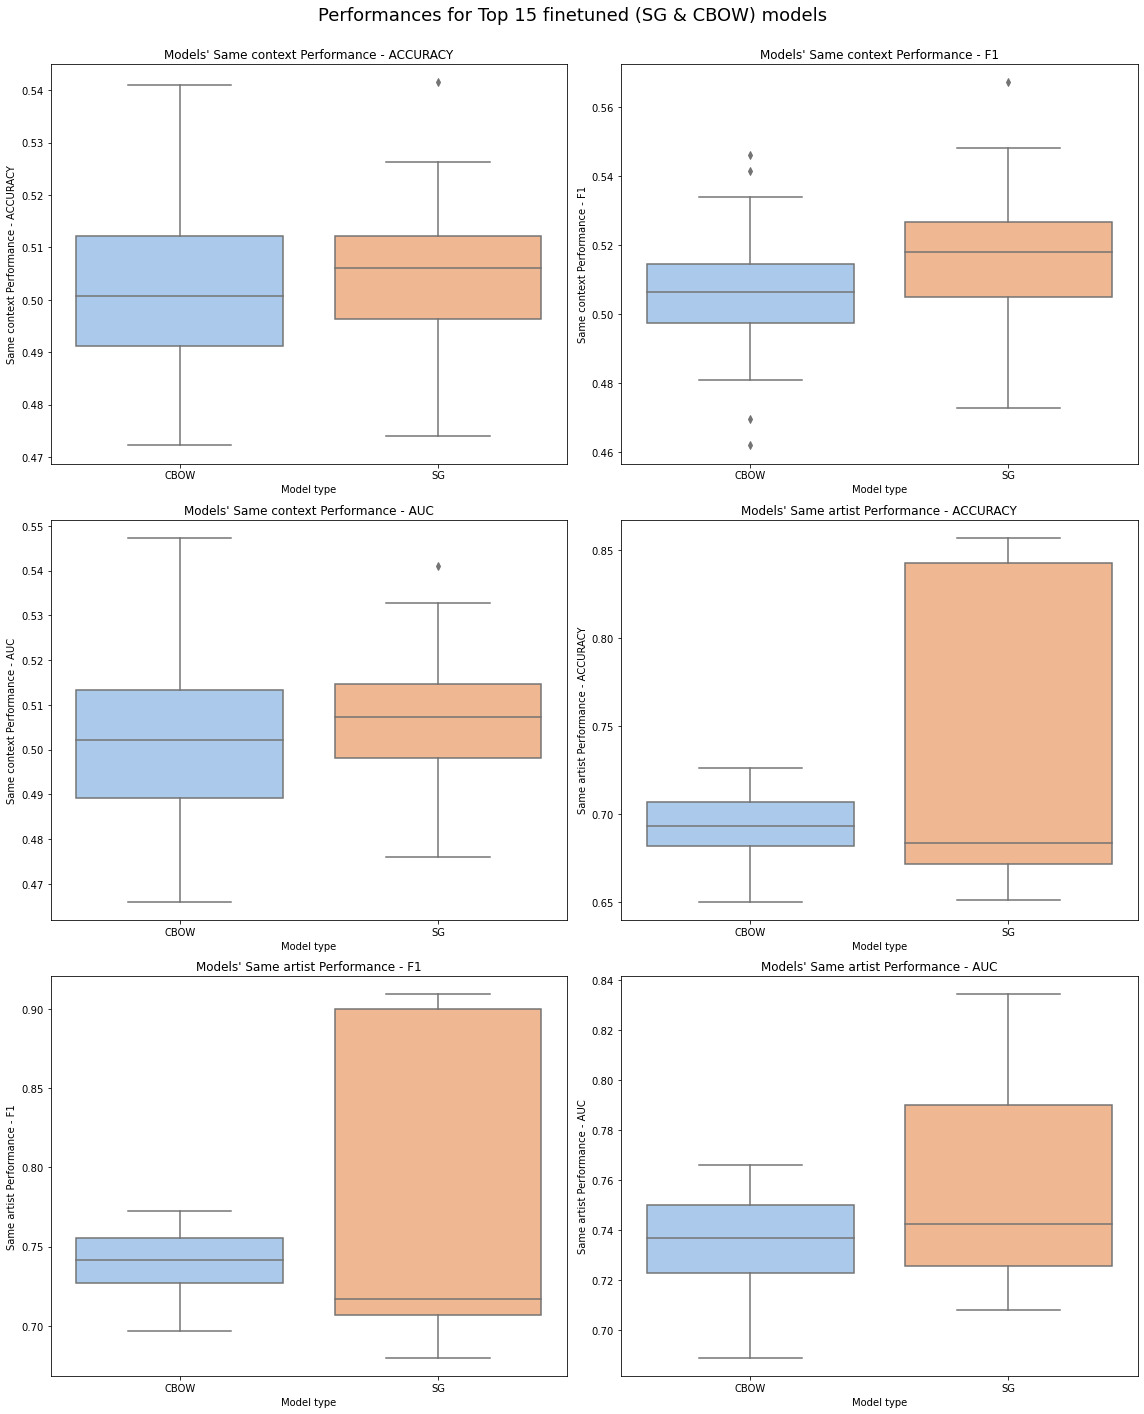

In [32]:
# plot both metrics
f, ax = plt.subplots(3, 2, figsize=(16,20))
ax = ax.ravel()
for i, metric in enumerate(['Same context Performance - ACCURACY', 'Same context Performance - F1',
                            'Same context Performance - AUC', 'Same artist Performance - ACCURACY', 
                            'Same artist Performance - F1', 'Same artist Performance - AUC']):
    sns.boxplot(data=models_metrics, x='Model type', y=metric, palette='pastel', ax=ax[i])
    ax[i].set_title(f'Models\' {metric}')
    ax[i].set_ylabel(metric)

plt.suptitle('Performances for Top 15 finetuned (SG & CBOW) models', fontsize = 18, )
plt.tight_layout()
f.subplots_adjust(top=0.94)
plt.show()

#### Evaluate them on the Tag classification task (which was not used to choose top 15 model configs)

##### Define task and helper functions

In [48]:
def pick_song_with_same_tag(discography, half_n):
    """Simply chooses random songs pair them with the previous or following one"""
    tags_with_multiple_songs = discography.groupby("top_tag")\
                                .agg(count=("track_name", "count")).reset_index()
    discography = discography.merge(tags_with_multiple_songs)
    song_pairs = discography.groupby("top_tag").agg(song1=("song_id", "first"), 
                                                        song2=("song_id", "last"))
    X = song_pairs.sample(half_n, random_state=SEED).values
    y = np.ones(half_n)
    return X, y

def pick_song_from_diff_tag(discography, half_n):
    discography = discography.drop_duplicates("top_tag")
    songs = discography.sample(2*half_n, random_state=SEED).song_id.values
    songs1 = songs[:half_n]
    songs2 = songs[half_n:]
    X = np.c_[songs1, songs2]
    y = np.zeros(half_n)
    return X, y

def create_tag_dataset(discography, s2v_df, n=20000):
    """Create a dataset of song pairs that either appeared in the same context or not""" 
    discography = discography[discography.song_id.isin(s2v_df.index)]
    X_pos, y_pos = pick_song_with_same_tag(discography, n//2)
    X_neg, y_neg = pick_song_from_diff_tag(discography, n//2)
    old_X = np.r_[X_pos, X_neg]
    old_y = np.r_[y_pos, y_neg]
    dataset = list(zip(old_X, old_y))
    np.random.seed(SEED)
    np.random.shuffle(dataset)
    X, y = zip(*dataset)
    return pd.DataFrame(X, columns=["song1", "song2"]), np.array(y)

In [65]:
def create_vectors_pairs(vectors, song_pairs):
    vector_pairs = vectors.merge(song_pairs, right_on="song1", left_index=True)
    vector_pairs = vector_pairs.merge(vectors, left_on="song2", right_index=True)
    vector_pairs = vector_pairs.drop(['song1', 'song2'], axis=1)

    assert len(vector_pairs) == len(song_pairs)
    assert vector_pairs.shape[1] == vectors.shape[1] * 2
    return vector_pairs

Load in the relevant dataframes, process them, and run the evaluation

In [40]:
top_tag_df = pd.read_csv('song_tags_df').drop(['tags'], axis=1)
top_tag_df.columns = ['artist_name', 'track_name', 'top_tag']

In [99]:
alphabetical_top_tag_df = pd.read_csv('data/song_tags_top1.csv').drop(['tags'], axis=1)
alphabetical_top_tag_df.columns = ['artist_name', 'track_name', 'top_tag']
alphabetical_top_tag_df.head()

,artist_name,track_name,top_tag
0,Boy Division,Love Will Tear Us Apart,joy division
1,Death Cab For Cutie,Soul Meets Body,indie
2,The Knife,Heartbeats,electronic
3,Muse,Starlight,alternative rock
4,The Killers,When You Were Young,rock


In [101]:
for dfs in [(user_history_df, 'baseline_df'), (merged_user_history_df, 'merged_artist_df'),
            (double_merged_user_history_df, 'fully_merged_df'), 
            (renamed_double_merged_user_history_df, 'renamed_merged_df')]:
    
    songs = dfs[0]
    songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                                + songs.track_name.cat.codes
    songs_with_tag_df = pd.merge(songs, alphabetical_top_tag_df, on=['artist_name','track_name']) # top_tag_df
    discography = songs_with_tag_df[["artist_name", "track_name", "top_tag", "song_id"]].drop_duplicates()
    
    
    df_name = dfs[1]
    init_iteration = 0
    performance_file_path = f'../word2vecs/finetuning/cbow_top15/_cbow_{df_name}_alphabetical_top_tag.csv'

    if init_iteration == 0:
        with open(performance_file_path, 'w') as f:
            f.write('model_path,accuracy,f1,auc\n')

    
    for perm_index in tqdm(cbow_top15):

        cbow_model_path = f"../word2vecs/finetuning/cbow_top15/{df_name}_{perm_index}_model.model"
        emb_vectors, model = load_model(cbow_model_path)
        
        s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())
        song_pairs, labels = create_tag_dataset(discography, s2v_df, 10000)

        # keep only songs with s2v embeddings
        s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

        X_train, X_test, y_train, y_test = \
                        train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
        acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

        with open(performance_file_path, 'a') as f:
            f.write(f'{cbow_model_path},{acc},{f1},{auc}\n')

        init_iteration = init_iteration + 1    

  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   5.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   5.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   5.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   5.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  10.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  10.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  10.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  10.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  10.6s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=  16.7s
[CV 2/5] END ...............

  7%|▋         | 1/15 [07:50<1:49:49, 470.67s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   9.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   9.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   9.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   9.0s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 2/15 [14:29<1:32:52, 428.69s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini, n

 20%|██        | 3/15 [17:21<1:02:17, 311.48s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 4/15 [20:10<46:43, 254.90s/it]  

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [23:16<38:23, 230.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   5.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   5.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   5.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   6.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   5.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  11.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  11.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  11.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  11.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  12.4s
[CV 1/5] END ...............criterion=gini,

 40%|████      | 6/15 [31:11<47:01, 313.48s/it]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=  11.5s
[CV 2/5] END ...............

 47%|████▋     | 7/15 [36:51<42:56, 322.09s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.3s
[CV 1/5] END ...............criterion=gini, n

 53%|█████▎    | 8/15 [42:31<38:14, 327.83s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   7.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   6.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   5.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   6.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   6.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  11.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  14.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=  14.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=  13.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=  13.6s
[CV 1/5] END ...............criterion=gini, n

 60%|██████    | 9/15 [52:07<40:32, 405.36s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 1/5] END ...............criterion=gini,

 67%|██████▋   | 10/15 [57:49<32:08, 385.70s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [1:03:54<25:17, 379.37s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 1/5] END ...............criterion=gini, n

 80%|████████  | 12/15 [1:09:37<18:25, 368.35s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.2s
[CV 1/5] END ...............criterion=gini, n

 87%|████████▋ | 13/15 [1:13:37<10:59, 329.54s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 1/5] END ...............criterion=gini, n_

 93%|█████████▎| 14/15 [1:19:47<05:41, 341.74s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 1/5] END ...............criterion=gini, n

100%|██████████| 15/15 [1:25:14<00:00, 340.94s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.1s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=  12.0s
[CV 2/5] END ...............

  7%|▋         | 1/15 [05:50<1:21:49, 350.71s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 1/5] END ...............criterion=gini

 13%|█▎        | 2/15 [11:11<1:12:09, 333.01s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n

 20%|██        | 3/15 [13:21<48:04, 240.38s/it]  

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 1/5] END ...............criterion=gini,

 27%|██▋       | 4/15 [15:26<35:41, 194.70s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [17:54<29:39, 177.94s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 1/5] END ...............criterion=gini

 40%|████      | 6/15 [23:18<34:09, 227.74s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 1/5] END ...............criterion=gini, n

 47%|████▋     | 7/15 [26:45<29:28, 221.03s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 1/5] END ...............criterion=gini, n

 53%|█████▎    | 8/15 [30:27<25:49, 221.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.1s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [36:15<26:03, 260.66s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 1/5] END ...............criterion=gini, n_

 67%|██████▋   | 10/15 [41:22<22:55, 275.20s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 1/5] END ...............criterion=gini, n_

 73%|███████▎  | 11/15 [46:58<19:35, 293.83s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 1/5] END ...............criterion=gini, n

 80%|████████  | 12/15 [51:56<14:44, 294.92s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 1/5] END ...............criterion=gini, n_

 87%|████████▋ | 13/15 [55:22<08:55, 267.92s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 1/5] END ...............criterion=gini, n_

 93%|█████████▎| 14/15 [1:00:52<04:46, 286.92s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 1/5] END ...............criterion=gini

100%|██████████| 15/15 [1:05:56<00:00, 263.79s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=  10.6s
[CV 2/5] END ...............

  7%|▋         | 1/15 [05:30<1:17:02, 330.14s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 1/5] END ...............criterion=gini, n

 13%|█▎        | 2/15 [10:30<1:07:47, 312.87s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_

 20%|██        | 3/15 [12:36<45:25, 227.14s/it]  

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 4/15 [14:32<33:40, 183.64s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 1/5] END ...............criterion=gini,

 33%|███▎      | 5/15 [17:07<28:51, 173.10s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 1/5] END ...............criterion=gini

 40%|████      | 6/15 [22:35<33:50, 225.63s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [26:00<29:11, 218.93s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 1/5] END ...............criterion=gini, n_

 53%|█████▎    | 8/15 [29:32<25:17, 216.75s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 1/5] END ...............criterion=gini, n

 60%|██████    | 9/15 [35:13<25:33, 255.60s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 1/5] END ...............criterion=gini, n_

 67%|██████▋   | 10/15 [40:25<22:45, 273.02s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [46:03<19:32, 293.08s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 1/5] END ...............criterion=gini, n

 80%|████████  | 12/15 [51:07<14:48, 296.28s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 1/5] END ...............criterion=gini, n

 87%|████████▋ | 13/15 [54:52<09:09, 274.78s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [1:00:12<04:48, 288.38s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 1/5] END ...............criterion=gini

100%|██████████| 15/15 [1:05:04<00:00, 260.33s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=  11.3s
[CV 2/5] END ...............

  7%|▋         | 1/15 [05:50<1:21:40, 350.06s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 1/5] END ...............criterion=gini, n

 13%|█▎        | 2/15 [11:14<1:12:36, 335.14s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini,

 20%|██        | 3/15 [13:22<48:06, 240.51s/it]  

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 4/15 [15:35<36:18, 198.01s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [18:06<30:09, 180.90s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 1/5] END ...............criterion=gini

 40%|████      | 6/15 [23:43<35:06, 234.05s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [27:22<30:33, 229.22s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 1/5] END ...............criterion=gini,

 53%|█████▎    | 8/15 [30:59<26:17, 225.40s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 1/5] END ...............criterion=gini, n_

 60%|██████    | 9/15 [36:58<26:42, 267.04s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 1/5] END ...............criterion=gini, n_

 67%|██████▋   | 10/15 [42:19<23:39, 283.83s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 1/5] END ...............criterion=gini, n

 73%|███████▎  | 11/15 [48:37<20:50, 312.67s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 12/15 [54:11<15:56, 319.00s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 13/15 [58:30<10:01, 300.86s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 1/5] END ...............criterion=gini,

 93%|█████████▎| 14/15 [1:04:02<05:10, 310.13s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 1/5] END ...............criterion=gini, n_

100%|██████████| 15/15 [1:09:23<00:00, 277.55s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}


In [102]:
for dfs in [(user_history_df, 'baseline_df'), (merged_user_history_df, 'merged_artist_df'),
            (double_merged_user_history_df, 'fully_merged_df'), 
            (renamed_double_merged_user_history_df, 'renamed_merged_df')]:
    
    songs = dfs[0]
    songs["song_id"]= songs.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                                + songs.track_name.cat.codes
    songs_with_tag_df = pd.merge(songs, alphabetical_top_tag_df, on=['artist_name','track_name']) # top_tag_df
    discography = songs_with_tag_df[["artist_name", "track_name", "top_tag", "song_id"]].drop_duplicates()
    
    
    df_name = dfs[1]
    init_iteration = 0
    performance_file_path = f'../word2vecs/finetuning/sg_top15/_sg_{df_name}_alphabetical_top_tag.csv'

    if init_iteration == 0:
        with open(performance_file_path, 'w') as f:
            f.write('model_path,accuracy,f1,auc\n')

    
    for perm_index in tqdm(sg_top15):

        sg_model_path = f"../word2vecs/finetuning/sg_top15/{df_name}_{perm_index}_model.model"
        emb_vectors, model = load_model(sg_model_path)
        
        s2v_df = pd.DataFrame(data=emb_vectors.values(), index=emb_vectors.keys())
        song_pairs, labels = create_tag_dataset(discography, s2v_df, 10000)

        # keep only songs with s2v embeddings
        s2v_pairs = create_vectors_pairs(s2v_df, song_pairs)

        X_train, X_test, y_train, y_test = \
                        train_test_split(s2v_pairs, labels, train_size=0.8, random_state=SEED)
        acc, f1, auc = predict_RF(X_train, X_test, y_train, y_test)

        with open(performance_file_path, 'a') as f:
            f.write(f'{sg_model_path},{acc},{f1},{auc}\n')

        init_iteration = init_iteration + 1    

  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   4.7s
[CV 2/5] END ...............

  7%|▋         | 1/15 [02:13<31:04, 133.20s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 1/5] END ...............criterion=gini,

 13%|█▎        | 2/15 [07:51<54:57, 253.67s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 1/5] END ...............criterion=gini

 20%|██        | 3/15 [13:37<59:12, 296.08s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 4/15 [19:25<57:59, 316.36s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 1/5] END ...............criterion=gini, n

 33%|███▎      | 5/15 [21:49<42:21, 254.15s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 6/15 [25:46<37:14, 248.33s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 1/5] END ...............criterion=gini,

 47%|████▋     | 7/15 [29:43<32:38, 244.84s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 1/5] END ...............criterion=gini

 53%|█████▎    | 8/15 [35:20<31:57, 273.97s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [40:54<29:17, 292.91s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 10/15 [43:38<21:05, 253.01s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n

 73%|███████▎  | 11/15 [46:18<14:58, 224.60s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.3s
[CV 1/5] END ...............criterion=gini, n

 80%|████████  | 12/15 [52:32<13:29, 269.98s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   5.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 1/5] END ...............criterion=gini, n

 87%|████████▋ | 13/15 [59:06<10:15, 307.77s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   9.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.5s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [1:06:50<05:54, 354.77s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 1/5] END ...............criterion=gini,

  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   5.5s
[CV 2/5] END ...............

  7%|▋         | 1/15 [02:40<37:28, 160.58s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.5s
[CV 1/5] END ...............criterion=gini,

 13%|█▎        | 2/15 [09:31<1:06:38, 307.57s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   9.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.9s
[CV 1/5] END ...............criterion=gini

 20%|██        | 3/15 [16:17<1:10:34, 352.88s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 1/5] END ...............criterion=gini, n

 27%|██▋       | 4/15 [22:45<1:07:10, 366.43s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n_

 33%|███▎      | 5/15 [25:24<48:39, 291.90s/it]  

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 1/5] END ...............criterion=gini,

 40%|████      | 6/15 [30:06<43:15, 288.44s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.6s
[CV 1/5] END ...............criterion=gini

 47%|████▋     | 7/15 [34:25<37:09, 278.73s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.1s
[CV 1/5] END ...............criterion=gini, n_

 53%|█████▎    | 8/15 [40:41<36:08, 309.76s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   9.2s
[CV 1/5] END ...............criterion=gini

 60%|██████    | 9/15 [47:27<33:58, 339.73s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.1s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 10/15 [51:04<25:10, 302.10s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n

 73%|███████▎  | 11/15 [54:25<18:03, 270.87s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   9.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   9.4s
[CV 1/5] END ...............criterion=gini, n

 80%|████████  | 12/15 [1:01:24<15:48, 316.11s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   5.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 1/5] END ...............criterion=gini,

 87%|████████▋ | 13/15 [1:07:44<11:10, 335.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   9.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   9.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   9.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   9.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.7s
[CV 1/5] END ...............criterion=gini

 93%|█████████▎| 14/15 [1:15:47<06:20, 380.05s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=  10.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=  10.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   9.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   9.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   9.1s
[CV 1/5] END ...............criterion=gini, n_

100%|██████████| 15/15 [1:24:21<00:00, 337.44s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   5.8s
[CV 2/5] END ...............

  7%|▋         | 1/15 [02:40<37:33, 161.00s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   5.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   9.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   9.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   8.6s
[CV 1/5] END ...............criterion=gini, n_

 13%|█▎        | 2/15 [09:25<1:05:53, 304.15s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 1/5] END ...............criterion=gini

 20%|██        | 3/15 [14:59<1:03:33, 317.79s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 1/5] END ...............criterion=gini

 27%|██▋       | 4/15 [20:51<1:00:44, 331.34s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini

 33%|███▎      | 5/15 [23:04<43:18, 259.86s/it]  

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   5.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 1/5] END ...............criterion=gini, n

 40%|████      | 6/15 [26:45<36:58, 246.55s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   5.1s
[CV 1/5] END ...............criterion=gini, n

 47%|████▋     | 7/15 [30:19<31:27, 235.93s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 1/5] END ...............criterion=gini, n_

 53%|█████▎    | 8/15 [35:17<29:50, 255.75s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 1/5] END ...............criterion=gini, n_

 60%|██████    | 9/15 [40:54<28:07, 281.26s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini, n_

 67%|██████▋   | 10/15 [43:43<20:32, 246.44s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 1/5] END ...............criterion=gini

 73%|███████▎  | 11/15 [46:34<14:53, 223.32s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 1/5] END ...............criterion=gini

 80%|████████  | 12/15 [52:23<13:04, 261.54s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 1/5] END ...............criterion=gini, n

 87%|████████▋ | 13/15 [57:33<09:12, 276.25s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.0s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 1/5] END ...............criterion=gini, n_

 93%|█████████▎| 14/15 [1:04:37<05:21, 321.01s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.4s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 1/5] END ...............criterion=gini, n

100%|██████████| 15/15 [1:11:16<00:00, 285.12s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}



  0%|          | 0/15 [00:00<?, ?it/s]

Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_estimators=150; total time=   4.6s
[CV 2/5] END ...............

  7%|▋         | 1/15 [02:10<30:25, 130.38s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   9.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   8.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.8s
[CV 1/5] END ...............criterion=gini, n

 13%|█▎        | 2/15 [07:23<51:34, 238.02s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 1/5] END ...............criterion=gini,

 20%|██        | 3/15 [12:37<54:30, 272.55s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.2s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 1/5] END ...............criterion=gini, n_

 27%|██▋       | 4/15 [17:45<52:33, 286.67s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.4s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   2.8s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   2.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   2.9s
[CV 1/5] END ...............criterion=gini, n_

 33%|███▎      | 5/15 [19:48<37:55, 227.58s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 1/5] END ...............criterion=gini,

 40%|████      | 6/15 [23:16<33:07, 220.81s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   2.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   2.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   2.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   4.9s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   4.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   4.7s
[CV 1/5] END ...............criterion=gini, n_

 47%|████▋     | 7/15 [26:43<28:51, 216.41s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.1s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.3s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 1/5] END ...............criterion=gini,

 53%|█████▎    | 8/15 [31:31<27:54, 239.23s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.7s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.6s
[CV 1/5] END ...............criterion=gini,

 60%|██████    | 9/15 [36:48<26:21, 263.51s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 150}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.4s
[CV 1/5] END ...............criterion=gini

 67%|██████▋   | 10/15 [39:30<19:20, 232.03s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   1.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   1.7s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   3.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   3.2s
[CV 1/5] END ...............criterion=gini,

 73%|███████▎  | 11/15 [42:12<14:02, 210.67s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.5s
[CV 1/5] END ...............criterion=gini, n_

 80%|████████  | 12/15 [47:58<12:36, 252.03s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.3s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   3.4s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.8s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   6.4s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.6s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   6.8s
[CV 1/5] END ...............criterion=gini

 87%|████████▋ | 13/15 [53:23<09:07, 273.99s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 100}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.9s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   4.3s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   4.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   4.2s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   8.2s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.7s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   8.9s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   9.3s
[CV 1/5] END ...............criterion=gini, n

 93%|█████████▎| 14/15 [1:00:34<05:21, 321.52s/it]

Best parameters are: {'criterion': 'entropy', 'n_estimators': 50}
Starting Grid search
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 2/5] END ................criterion=gini, n_estimators=50; total time=   4.1s
[CV 3/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 4/5] END ................criterion=gini, n_estimators=50; total time=   3.5s
[CV 5/5] END ................criterion=gini, n_estimators=50; total time=   3.6s
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   7.3s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   7.1s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   7.0s
[CV 1/5] END ...............criterion=gini,

100%|██████████| 15/15 [1:07:26<00:00, 269.78s/it]

Best parameters are: {'criterion': 'gini', 'n_estimators': 150}


#### View results

In [103]:
df_names = ['baseline_df', 'merged_artist_df', 'fully_merged_df', 'renamed_merged_df']

cbow_top_tag_merged_df = pd.read_csv(f'../word2vecs/finetuning/cbow_top15/_cbow_{df_names[0]}_alphabetical_top_tag.csv')
cbow_top_tag_merged_df['model_df'] = df_names[0]

for other_dfs in df_names[1:]:
    tmp_df = pd.read_csv(f'../word2vecs/finetuning/cbow_top15/_cbow_{other_dfs}_top_tag.csv')
    tmp_df['model_df'] = other_dfs

    cbow_top_tag_merged_df = pd.concat([cbow_top_tag_merged_df, tmp_df], ignore_index=True)
    
sg_top_tag_merged_df = pd.read_csv(f'../word2vecs/finetuning/sg_top15/_sg_{df_names[0]}_alphabetical_top_tag.csv')
sg_top_tag_merged_df['model_df'] = df_names[0]

for other_dfs in df_names[1:]:
    tmp_df = pd.read_csv(f'../word2vecs/finetuning/sg_top15/_sg_{other_dfs}_top_tag.csv')
    tmp_df['model_df'] = other_dfs

    sg_top_tag_merged_df = pd.concat([sg_top_tag_merged_df, tmp_df], ignore_index=True)

In [104]:
# "merge" all metrics into a single table so that confidence intervals can later be plotted
models_metrics = []
for model, model_df, tt_acc, tt_f1, tt_auc  in [
    ('CBOW', cbow_top_tag_merged_df.model_df.values, cbow_top_tag_merged_df.accuracy.values, 
     cbow_top_tag_merged_df.f1.values, cbow_top_tag_merged_df.auc.values),
    ('SG', sg_top_tag_merged_df.model_df.values, sg_top_tag_merged_df.accuracy.values, 
     sg_top_tag_merged_df.f1.values, sg_top_tag_merged_df.auc.values)]:
    
    for i in range(len(model_df)):
        models_metrics.append([model, model_df[i], tt_acc[i], tt_f1[i], tt_auc[i]])
        
models_metrics = pd.DataFrame(models_metrics, columns=['Model type',
                                                       'Models DF',
                                                       'Top tag Performance - ACCURACY',
                                                       'Top tag Performance - F1',
                                                       'Top tag Performance - AUC'])

# models_metrics.to_pickle('../word2vecs/finetuning/top15_alphabetical_top_tag_metrics')

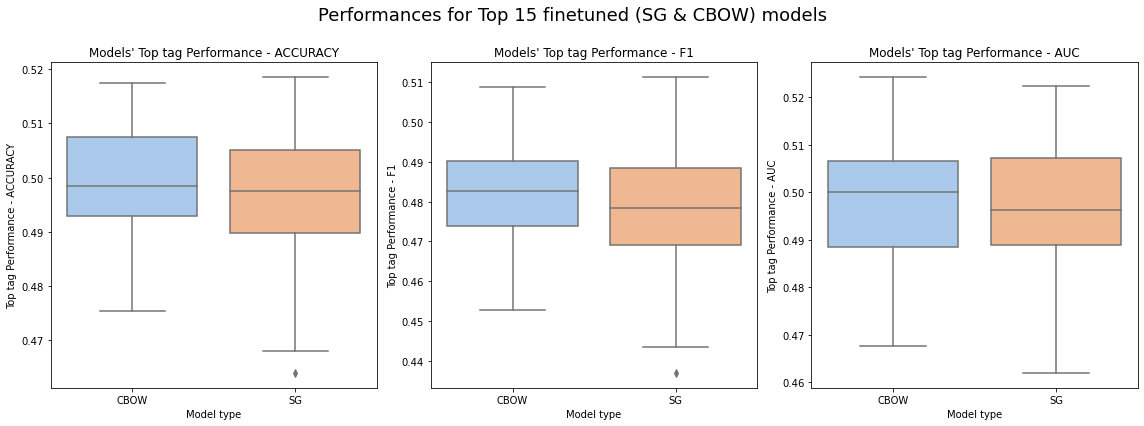

In [105]:
# plot both metrics
f, ax = plt.subplots(1, 3, figsize=(16,6))
ax = ax.ravel()
for i, metric in enumerate(['Top tag Performance - ACCURACY', 'Top tag Performance - F1',
                            'Top tag Performance - AUC']):
    sns.boxplot(data=models_metrics, x='Model type', y=metric, palette='pastel', ax=ax[i])
    ax[i].set_title(f'Models\' {metric}')
    ax[i].set_ylabel(metric)

plt.suptitle('Performances for Top 15 finetuned (SG & CBOW) models', fontsize = 18, )
plt.tight_layout()
f.subplots_adjust(top=0.85)
plt.show()